# Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from rdkit import Chem
import rdkit.Chem.PandasTools as PandasTools
from rdkit.Chem import QED
from rdkit.Chem import AllChem

PandasTools.InstallPandasTools()

In [4]:
from IPython.display import HTML

In [5]:
from scipy.spatial import distance

In [6]:
import os
from collections import defaultdict

### Analysis Variables

In [7]:
blob = "lig_gen"

Maximum RMSD threshold used for filtering molecules with low RMSD between generated and minimised structure:

In [8]:
maxRMSD = 1.0

Minimum QED threshold used for filtering:

In [9]:
minQED = 0.8

Suffixes of RMSD files:

In [10]:
rmsdtypes = ["uff", "vina"]

In [11]:
maxVina = -7

In [12]:
minCNNscore = 0.7

### Helper Functions

TODO: Extract such functions in a Python module.

In [13]:
def root_and_prefix(datafile):
    """
    Root directory and prefix.
    """
    dataroot = os.path.dirname(datafile)
    prefix, _ = os.path.splitext(os.path.basename(datafile))

    return dataroot, prefix

In [14]:
def load_rmsd(dataroot, prefix, df):
    """
    Load ligand RMSD CSV files and add RMSD to DataFrame
    """
    ligands = df["lig_name"].unique()

    # Load RMSDs
    for ligand in ligands:
        for rmsdtype in rmsdtypes:
            fname = os.path.join(
                dataroot, prefix + "_" + ligand + f"_{blob}_RMSD{rmsdtype}.csv"
            )
            df_rmsd = pd.read_csv(fname)

            # Assign ligand RMSD to general dataset
            # Assumes sample indices are in the same order (but indices might be missing from RMSD dataframe)
            df.loc[
                (df["sample_idx"].isin(df_rmsd["sample"])) & (df["lig_name"] == ligand),
                f"rmsd_{rmsdtype}",
            ] = df_rmsd["rmsd"].to_numpy()

    # Drop all samples for which the RMSD between generated and minimised structures
    # could not be computed (reconstruction failed):
    nall = len(df)
    df.dropna(subset=[f"rmsd_{rt}" for rt in rmsdtypes], inplace=True)

    print(f"Successfully reconstructed molecules: {len(df) / nall * 100:.2f}%")

In [15]:
def load_scores(dataroot, prefix, df):
    ligands = df["lig_name"].unique()

    for ligand in ligands:
        fname = os.path.join(dataroot, prefix + "_" + ligand + f"_{blob}_scores.csv")
        df_scores = pd.read_csv(fname)

        # Assign scores to general dataset
        # Assumes sample indices are in the same order (but indices might be missing from RMSD dataframe)
        scores = ["vinaaffinity", "cnnscore", "cnnaffinity"]
        df.loc[
            (df["sample_idx"].isin(df_scores["sample"])) & (df["lig_name"] == ligand),
            scores,
        ] = df_scores[scores].to_numpy()

In [16]:
def rmsd_statistics(df, mRMSD):

    for rt in rmsdtypes:
        rmsd = df[f"rmsd_{rt}"].to_numpy()

        print(f"--- {rt.upper()} ---")
        print(f"Average RMSD: {np.mean(rmsd)}")
        print(f"Median RMSD: {np.median(rmsd)}")
        print(
            f"Percentage of low-RMSD samples: {np.logical_and(rmsd < mRMSD, rmsd > 0.05).sum() / len(rmsd)  * 100}%"
        )

In [17]:
def filter(df, mRMSD, mQED):
    # Some systems have 0.0 RMSD
    df_lowrmsd = df[(df.rmsd_vina < mRMSD) & (df.rmsd_vina > 0.05)].copy()

    # Sort by RMSD, so that fropping duplicates will retain lowest RMSD
    df_lowrmsd.sort_values(by="rmsd_vina", ascending=True, inplace=True)
    df_lowrmsd = df_lowrmsd.drop_duplicates(
        subset=[f"{blob}_fit_add_SMILES"], keep="first"
    )

    # Add RDKit molecule
    PandasTools.AddMoleculeColumnToFrame(
        df_lowrmsd, f"{blob}_fit_add_SMILES", f"mol_{blob}"
    )

    return df_lowrmsd[df_lowrmsd[f"{blob}_fit_add_QED"] > mQED]

In [18]:
def load_prior(prefix):
    datadict = defaultdict(list)

    s = Chem.SDMolSupplier(f"generated/{prefix}_ligand-1_min_lig_gen_vina.sdf")

    for mol in s:
        if mol is not None:
            AllChem.Compute2DCoords(mol)  # Needed for 2D visualisation

            datadict["lig_name"].append(
                "ligand-1_min"
            )  # Ligand used to defined binding site
            datadict["sample_idx"].append(mol.GetProp("_Name"))
            datadict["mol"].append(mol)
            datadict["vinaaffinity"].append(float(mol.GetProp("minimizedAffinity")))
            datadict["cnnscore"].append(float(mol.GetProp("CNNscore")))
            datadict["cnnaffinity"].append(float(mol.GetProp("CNNaffinity")))
            datadict["QED"].append(QED.qed(mol))

    return pd.DataFrame.from_dict(datadict)

In [19]:
def load_latent(prefix, n_samples, latent_size=512):
    L = np.zeros((n_samples, latent_size))

    for i in range(n_samples):
        L[i, :] = np.loadtxt(f"generated/{prefix}_ligand-1_min_lig_gen_{i}.latent")

    return L

## Variability Factor 0.5

### Data

In [20]:
datafile = "generated/BRD4_vf0.5_big.gen_metrics"

Load generative model metrics (from `*.gen_metrics` file):

In [21]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'BRD4_vf0.5_big'

In [22]:
df = pd.read_csv(datafile, sep=" ")
df.head()

lig_name  sample_idx   lig_norm  lig_variance  lig_gen_norm  \
0  ligand-1_min           0  32.281212           NaN     29.722475   
1  ligand-1_min           1  32.281212           NaN     30.030760   
2  ligand-1_min           2  32.281212           NaN     29.536850   
3  ligand-1_min           3  32.281212           NaN     30.892813   
4  ligand-1_min           4  32.281212           NaN     30.221460   

   lig_gen_variance  lig_gen_L2_loss  lig_gen_L1_loss  lig_latent_norm  \
0               NaN        27.148872       774.018005        12.905028   
1               NaN        31.770716       804.161011        13.174235   
2               NaN        37.090858       835.086487        12.596121   
3               NaN        21.801115       748.488525        13.416719   
4               NaN        32.425076       802.728699        13.286654   

   lig_latent_variance  ...  lig_gen_fit_add_E  lig_gen_fit_add_min_E  \
0                  NaN  ...       2.588493e+07              58.036857   
1                  NaN  ...       2.520094e+03             426.320145   
2                  NaN  ...       1.459760e+05              21.761633   
3                  NaN  ...       1.308772e+05              40.584422   
4                  NaN  ...       1.726348e+07             426.054428   

   lig_gen_fit_add_dE_min  lig_gen_fit_add_min_error  \
0           -2.588487e+07                        NaN   
1           -2.093774e+03                        NaN   
2           -1.459543e+05                        NaN   
3           -1.308366e+05                        NaN   
4           -1.726305e+07                        NaN   

   lig_gen_fit_add_min_time  lig_gen_fit_add_RMSD_min  lig_gen_fit_add_dE_ref  \
0                  0.061071                  1.445712            2.588486e+07   
1                  0.005782                  0.631245            2.446503e+03   
2                  0.010970                  1.303365            1.459024e+05   
3                  0.012285                  1.228601            1.308036e+05   
4                  0.017585                  1.066857            1.726340e+07   

   lig_gen_fit_add_min_dE_ref  lig_gen_fit_add_RMSD_ref  \
0                  -15.553581                       NaN   
1                  352.729708                       NaN   
2                  -51.828805                       NaN   
3                  -33.006016                       NaN   
4                  352.463990                       NaN   

   lig_gen_fit_add_min_RMSD_ref  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  

[5 rows x 125 columns]

Available metrics:

In [23]:
print([c for c in df.columns])

['lig_name', 'sample_idx', 'lig_norm', 'lig_variance', 'lig_gen_norm', 'lig_gen_variance', 'lig_gen_L2_loss', 'lig_gen_L1_loss', 'lig_latent_norm', 'lig_latent_variance', 'lig_fit_norm', 'lig_fit_variance', 'lig_fit_L2_loss', 'lig_fit_L1_loss', 'lig_gen_fit_norm', 'lig_gen_fit_variance', 'lig_gen_fit_L2_loss', 'lig_gen_fit_L1_loss', 'lig_n_atoms', 'lig_radius', 'lig_fit_n_atoms', 'lig_fit_radius', 'lig_fit_type_diff', 'lig_fit_exact_types', 'lig_fit_RMSD', 'lig_fit_time', 'lig_fit_n_visited', 'lig_est_type_diff', 'lig_est_exact_types', 'lig_gen_fit_n_atoms', 'lig_gen_fit_radius', 'lig_gen_fit_type_diff', 'lig_gen_fit_exact_types', 'lig_gen_fit_RMSD', 'lig_gen_fit_time', 'lig_gen_fit_n_visited', 'lig_gen_est_type_diff', 'lig_gen_est_exact_types', 'lig_n_frags', 'lig_error', 'lig_valid', 'lig_MW', 'lig_logP', 'lig_QED', 'lig_SAS', 'lig_NPS', 'lig_SMILES', 'lig_E', 'lig_min_E', 'lig_dE_min', 'lig_min_error', 'lig_min_time', 'lig_RMSD_min', 'lig_add_n_frags', 'lig_add_error', 'lig_add_vali

Load RMSD calculations (between generated and minimised structures) for each ligand:

In [24]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 92.25%


In [25]:
load_scores(dataroot, prefix, df)

In [26]:
df.head()

lig_name  sample_idx   lig_norm  lig_variance  lig_gen_norm  \
0  ligand-1_min           0  32.281212           NaN     29.722475   
1  ligand-1_min           1  32.281212           NaN     30.030760   
2  ligand-1_min           2  32.281212           NaN     29.536850   
3  ligand-1_min           3  32.281212           NaN     30.892813   
4  ligand-1_min           4  32.281212           NaN     30.221460   

   lig_gen_variance  lig_gen_L2_loss  lig_gen_L1_loss  lig_latent_norm  \
0               NaN        27.148872       774.018005        12.905028   
1               NaN        31.770716       804.161011        13.174235   
2               NaN        37.090858       835.086487        12.596121   
3               NaN        21.801115       748.488525        13.416719   
4               NaN        32.425076       802.728699        13.286654   

   lig_latent_variance  ...  lig_gen_fit_add_RMSD_min  lig_gen_fit_add_dE_ref  \
0                  NaN  ...                  1.445712            2.588486e+07   
1                  NaN  ...                  0.631245            2.446503e+03   
2                  NaN  ...                  1.303365            1.459024e+05   
3                  NaN  ...                  1.228601            1.308036e+05   
4                  NaN  ...                  1.066857            1.726340e+07   

   lig_gen_fit_add_min_dE_ref  lig_gen_fit_add_RMSD_ref  \
0                  -15.553581                       NaN   
1                  352.729708                       NaN   
2                  -51.828805                       NaN   
3                  -33.006016                       NaN   
4                  352.463990                       NaN   

   lig_gen_fit_add_min_RMSD_ref  rmsd_uff  rmsd_vina  vinaaffinity  cnnscore  \
0                           NaN   1.24900    0.90406      -5.16906  0.331674   
1                           NaN   0.63125    0.63124      -7.14382  0.624230   
2                           NaN   1.30335    1.21697       4.57602  0.520601   
3                           NaN   1.22860    1.11196      -4.73783  0.329395   
4                           NaN   1.06685    1.00756      -1.93421  0.474065   

   cnnaffinity  
0     4.609689  
1     4.869042  
2     4.503659  
3     4.155893  
4     4.475141  

[5 rows x 130 columns]

### Molecules

In [27]:
# Add RDKit molecule
PandasTools.AddMoleculeColumnToFrame(df, f"{blob}_fit_add_SMILES", f"mol_{blob}")

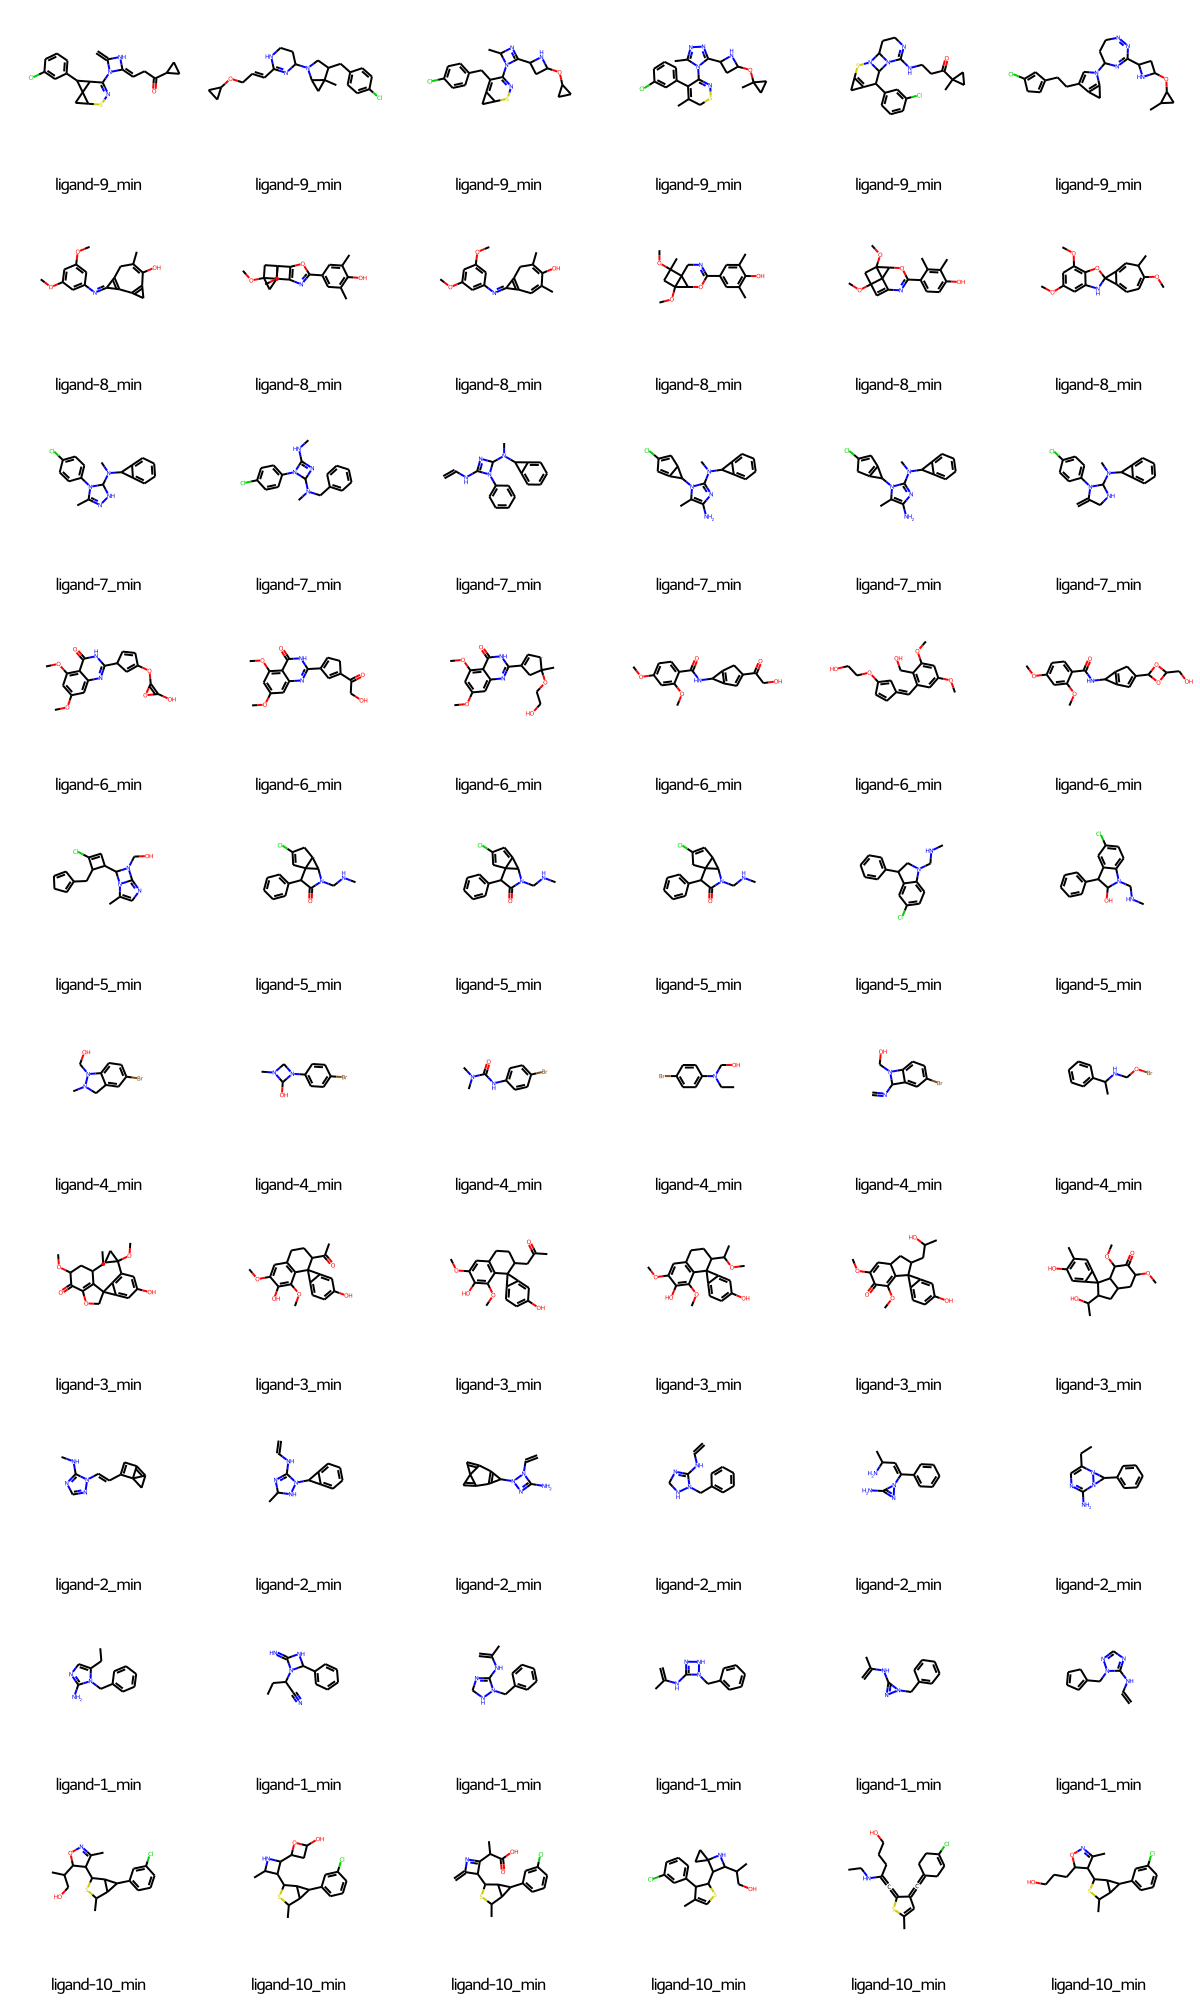

In [28]:
img = PandasTools.FrameToGridImage(
    df.drop_duplicates(subset=f"{blob}_fit_add_SMILES")
    .sort_values(by=["lig_name", f"{blob}_fit_add_QED"], ascending=False)
    .groupby("lig_name")
    .head(6)
    .reset_index(drop=True),
    column=f"mol_{blob}",
    legendsCol=f"lig_name",
    molsPerRow=6,
    maxMols=60,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [29]:
img.save(os.path.join("plots", prefix + "_topQED.png"))

### Distributions

#### RMSD

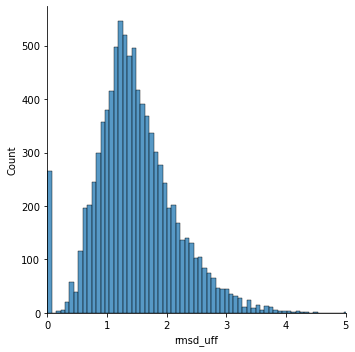

In [30]:
sns.displot(df["rmsd_uff"])
plt.xlim([0, 5])
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.png"))

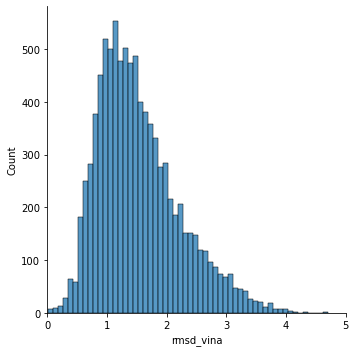

In [31]:
sns.displot(df["rmsd_vina"])
plt.xlim([0, 5])
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.png"))

Systems with 0.0 RMSD UFF are systems for which the minimisation failed (the generated molecule is not minimied but the minimised output is nonetheless produced). Some failures are due to `Unrecognized charge state for atoms: #X` while other are not better specified `UFF Exception` problems.

#### QED

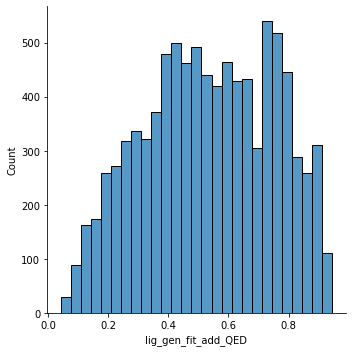

In [32]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

#### Scores

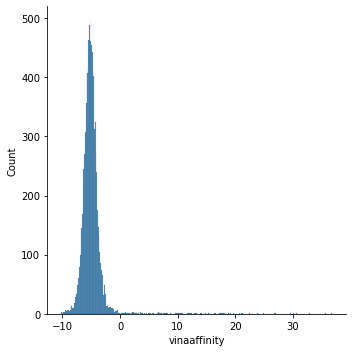

In [33]:
sns.displot(df[f"vinaaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distVina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distVina.png"))

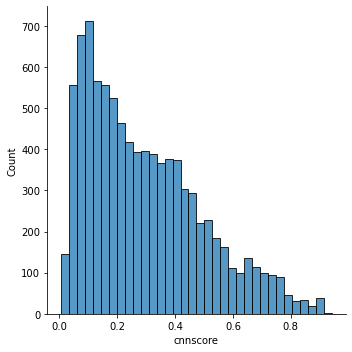

In [34]:
sns.displot(df["cnnscore"])
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.png"))

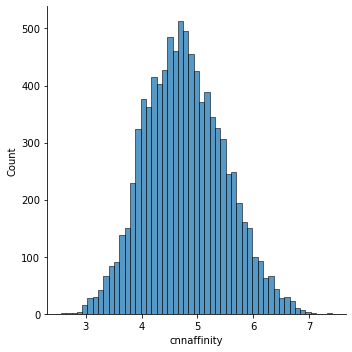

In [35]:
sns.displot(df["cnnaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.png"))

### Simple Statistics

In [36]:
rmsd_statistics(df, maxRMSD)

--- UFF ---
Average RMSD: 1.484511436314363
Median RMSD: 1.40745
Percentage of low-RMSD samples: 18.601626016260163%
--- VINA ---
Average RMSD: 1.537787030894309
Median RMSD: 1.41291
Percentage of low-RMSD samples: 22.742547425474253%


### Correlation

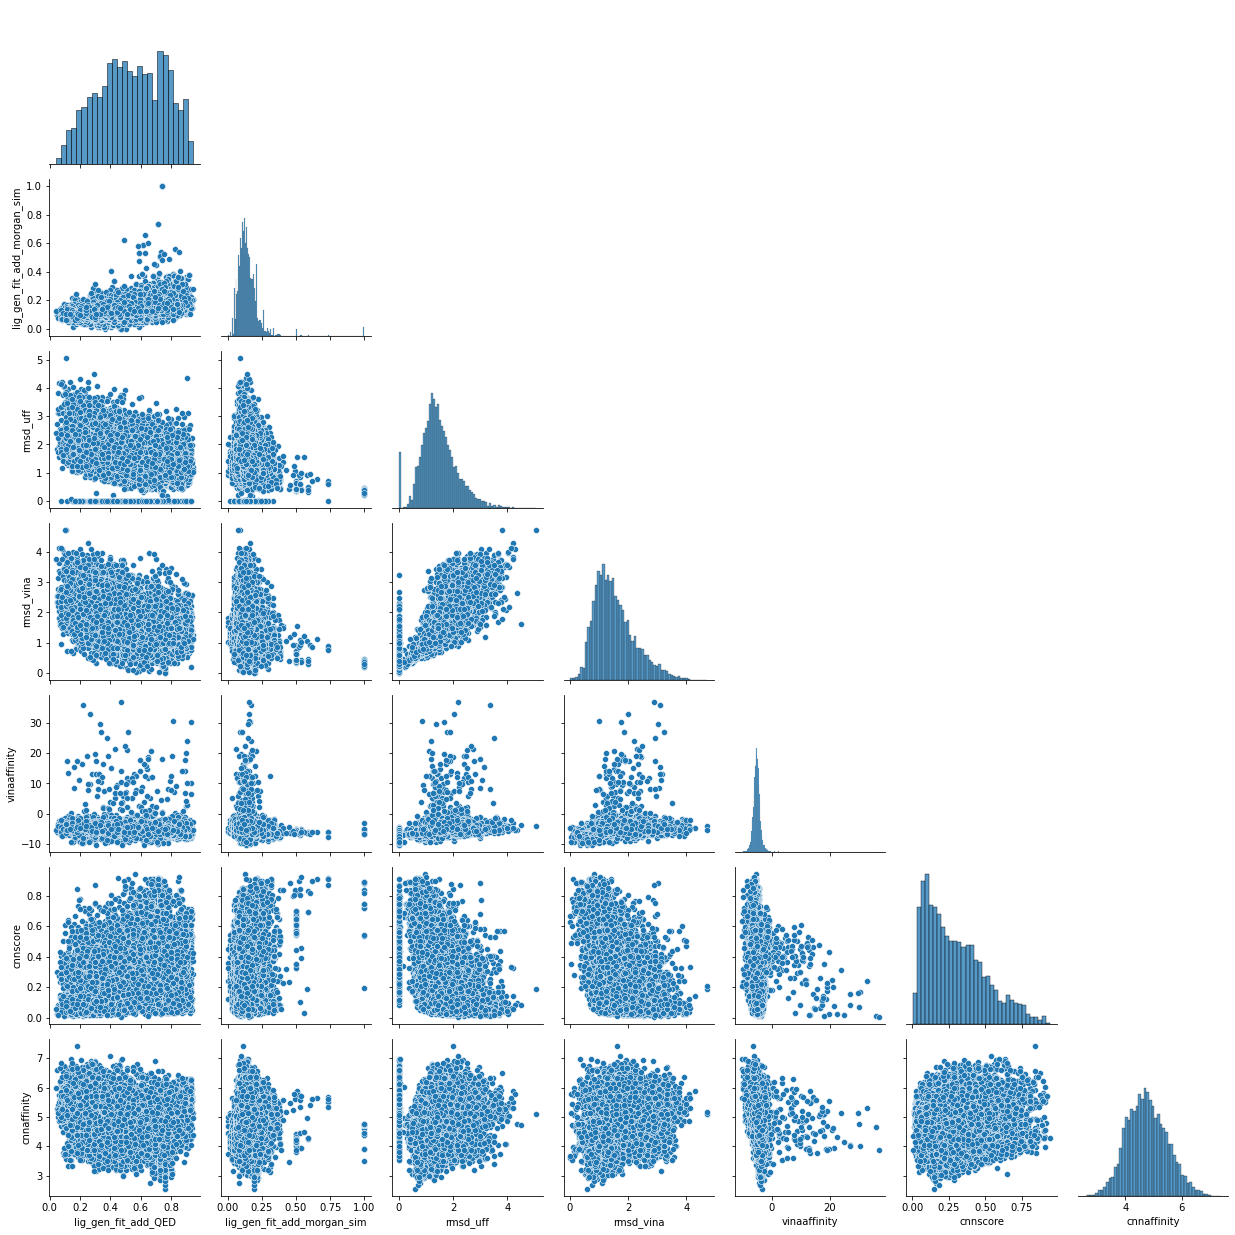

In [37]:
to_plot = [
    f"{blob}_fit_add_QED",
    f"{blob}_fit_add_morgan_sim",
    "rmsd_uff",
    "rmsd_vina",
    "vinaaffinity",
    "cnnscore",
    "cnnaffinity",
]

g = sns.PairGrid(df[to_plot], corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.savefig(os.path.join("plots", prefix + "_correlations.pdf"))
plt.savefig(os.path.join("plots", prefix + "_correlations.png"))

### Filter Molecules

In [38]:
df_filtered = filter(df, maxRMSD, minQED)

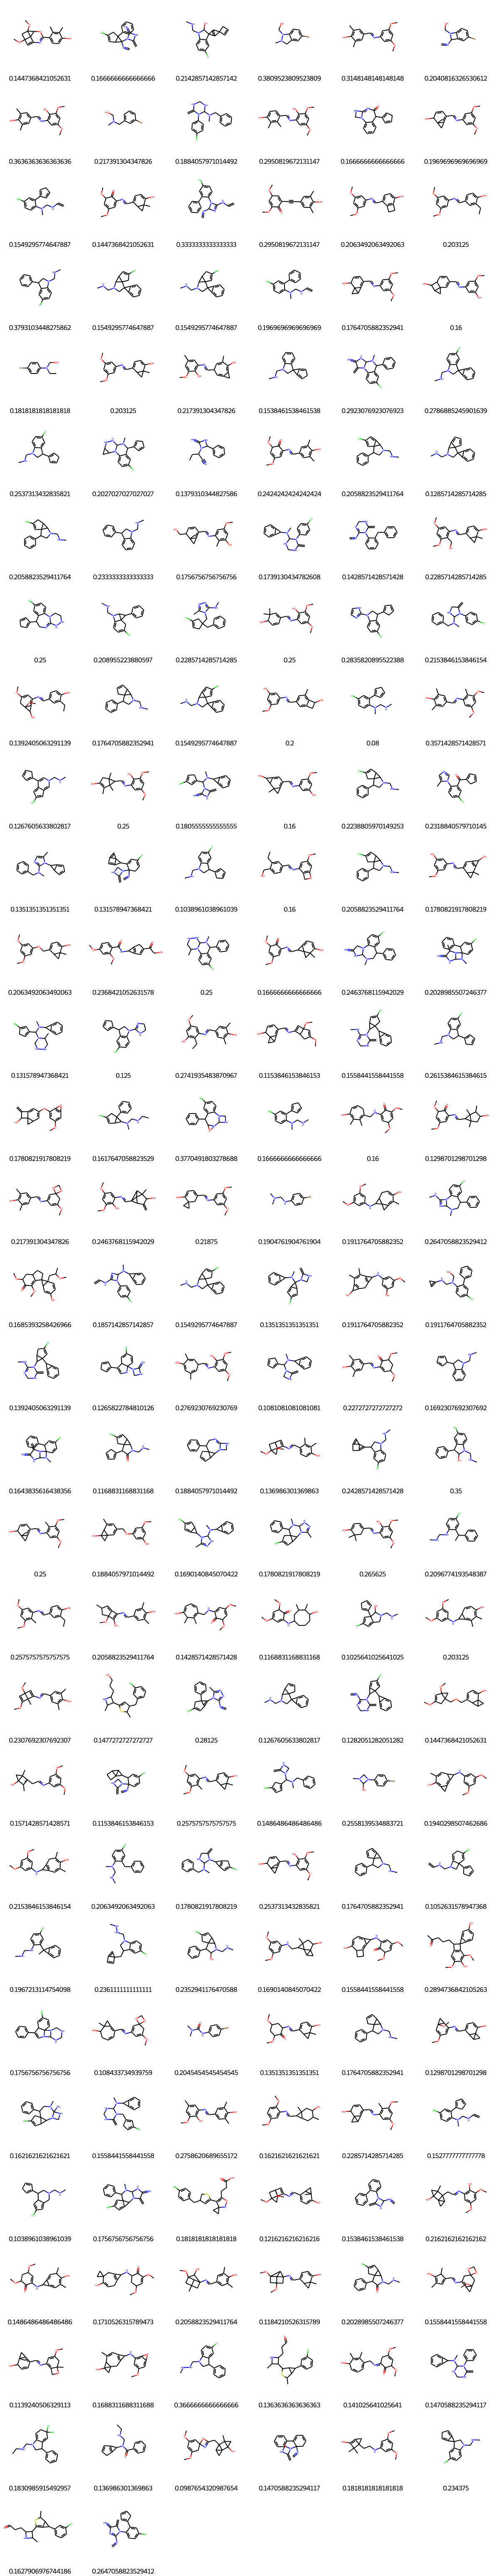

In [39]:
img = PandasTools.FrameToGridImage(
    df_filtered,
    column=f"mol_{blob}",
    legendsCol=f"{blob}_fit_add_morgan_sim",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [40]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [41]:
len(df_filtered)

182

In [42]:
dfcolumns = [
    "lig_name",
    "sample_idx",
    "lig_gen_fit_add_morgan_sim",
    "rmsd_uff",
    "rmsd_vina",
    "vinaaffinity",
    "cnnscore",
    "cnnaffinity",
    "mol_lig_gen",
]

lig_name  sample_idx  lig_gen_fit_add_morgan_sim  rmsd_uff  \
4065  ligand-5_min          65                    0.166667   0.00000   
4794  ligand-5_min         794                    0.214286   0.00000   
6439  ligand-7_min         439                    0.188406   0.00000   
7304  ligand-8_min         304                    0.196970   0.50900   
4162  ligand-5_min         162                    0.154930   0.00000   
6348  ligand-7_min         348                    0.333333   0.00000   
7351  ligand-8_min         351                    0.206349   0.44661   
4039  ligand-5_min          39                    0.196970   0.00000   
7385  ligand-8_min         385                    0.176471   0.43107   
7564  ligand-8_min         564                    0.203125   0.51298   
7577  ligand-8_min         577                    0.217391   1.01235   
6794  ligand-7_min         794                    0.292308   0.72506   
4893  ligand-5_min         893                    0.205882   0.82748   
6297  ligand-7_min         297                    0.173913   0.00000   
7639  ligand-8_min         639                    0.228571   0.00015   
4308  ligand-5_min         308                    0.250000   0.74863   
4167  ligand-5_min         167                    0.283582   0.70920   
6484  ligand-7_min         484                    0.215385   0.00000   
7580  ligand-8_min         580                    0.200000   0.70631   
7857  ligand-8_min         857                    0.357143   0.59562   
7798  ligand-8_min         798                    0.178082   0.73205   
7469  ligand-8_min         469                    0.206349   1.16263   
6316  ligand-7_min         316                    0.250000   0.94238   
6633  ligand-7_min         633                    0.246377   0.85398   
6843  ligand-7_min         843                    0.131579   0.00000   
7079  ligand-8_min          79                    0.178082   1.13398   
4569  ligand-5_min         569                    0.377049   0.75165   
7394  ligand-8_min         394                    0.217391   0.57228   
6483  ligand-7_min         483                    0.264706   0.86982   
6919  ligand-7_min         919                    0.135135   0.00005   
4286  ligand-5_min         286                    0.116883   0.76646   
7526  ligand-8_min         526                    0.136986   0.82789   
7414  ligand-8_min         414                    0.250000   0.76588   
7785  ligand-8_min         785                    0.188406   0.97960   
6478  ligand-7_min         478                    0.169014   0.00000   
6408  ligand-7_min         408                    0.178082   0.88345   
7574  ligand-8_min         574                    0.257576   0.63969   
7335  ligand-8_min         335                    0.205882   0.84538   
7796  ligand-8_min         796                    0.257576   0.75781   
7163  ligand-8_min         163                    0.194030   1.25425   
6023  ligand-7_min          23                    0.178082   0.00000   
7647  ligand-8_min         647                    0.253731   0.67794   
7759  ligand-8_min         759                    0.129870   0.65381   
6783  ligand-7_min         783                    0.155844   0.00000   
7173  ligand-8_min         173                    0.205882   1.41609   

      rmsd_vina  vinaaffinity  cnnscore  cnnaffinity  \
4065    0.32269      -8.36335  0.577137     5.635641   
4794    0.32657      -7.23591  0.346724     5.387923   
6439    0.54284      -8.20135  0.594477     6.016396   
7304    0.60855      -7.13052  0.701105     5.152256   
4162    0.61284      -7.05425  0.419318     5.181843   
6348    0.63508      -7.91718  0.767578     5.913103   
7351    0.64526      -7.31483  0.723221     5.306442   
4039    0.67808      -7.37486  0.513096     5.083523   
7385    0.67870      -7.11971  0.608864     5.185603   
7564    0.69106      -7.00024  0.641062     5.147220   
7577    0.71003      -7.04636  0.623124     5.411789   
6794    0.72244      -8.4
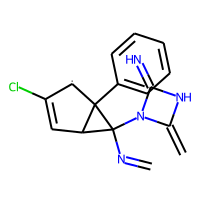
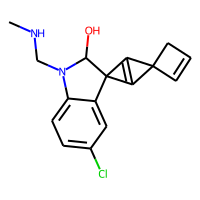
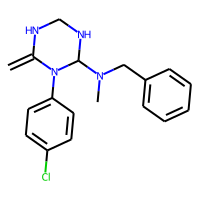
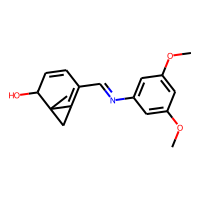
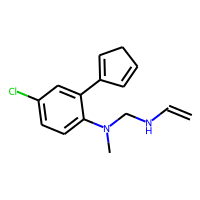
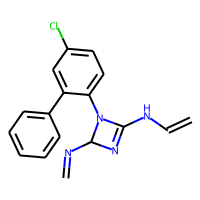
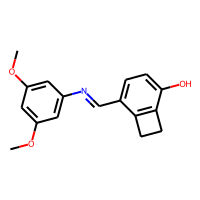
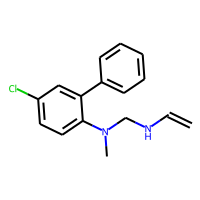
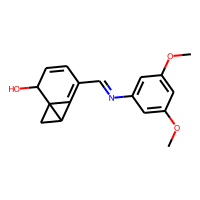
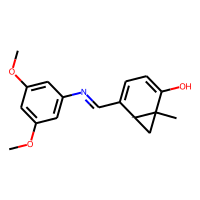
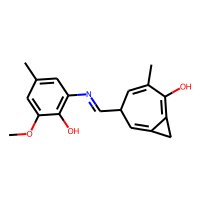
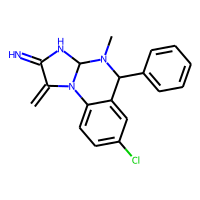
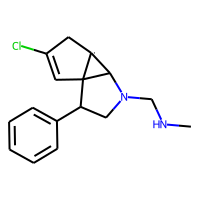
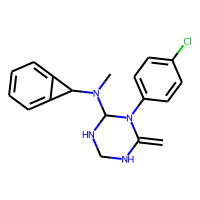
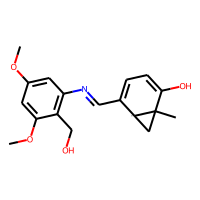
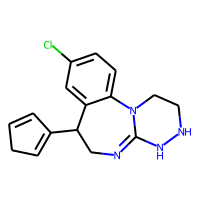
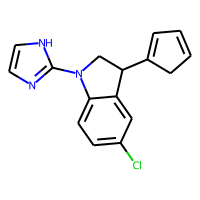
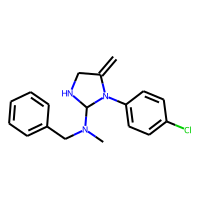
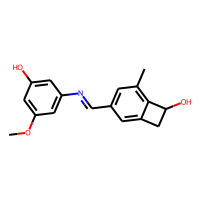
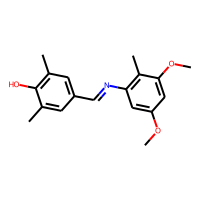
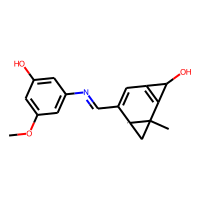
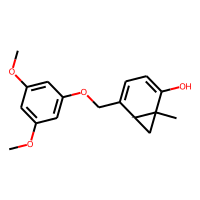
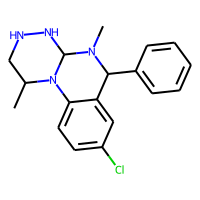
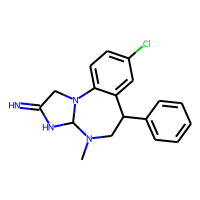
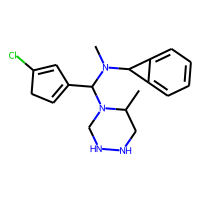
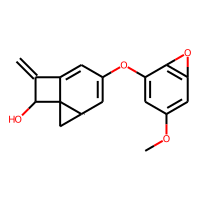
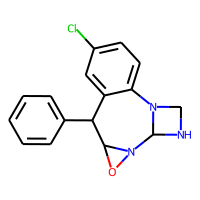
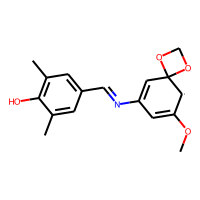
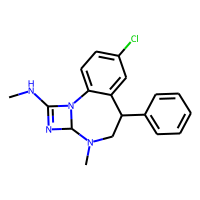
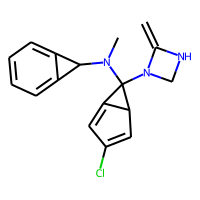
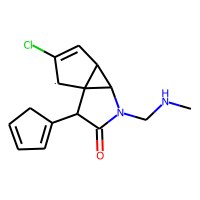
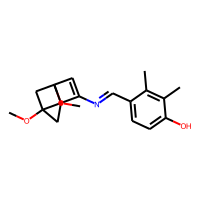
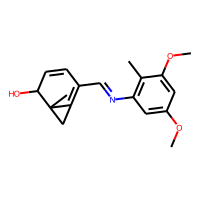
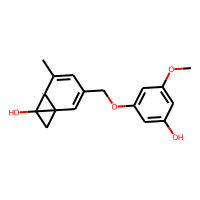
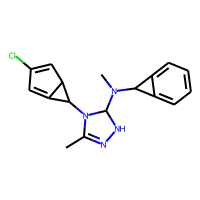
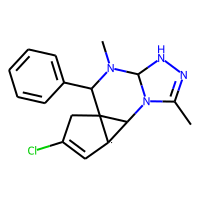
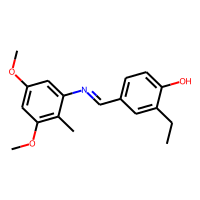
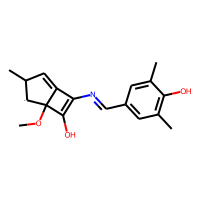
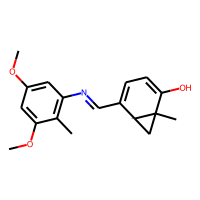
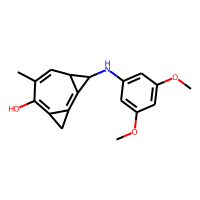
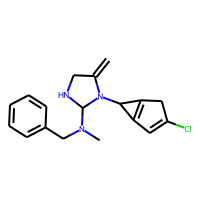
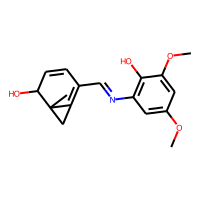
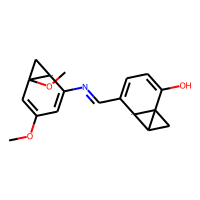
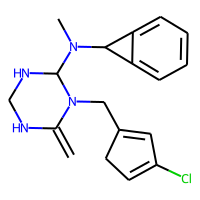
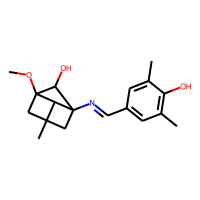

In [43]:
df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]

lig_name  sample_idx  lig_gen_fit_add_morgan_sim  rmsd_uff  \
7377  ligand-8_min         377                    0.144737   0.00008   
7548  ligand-8_min         548                    0.314815   0.59290   
7304  ligand-8_min         304                    0.196970   0.50900   
6348  ligand-7_min         348                    0.333333   0.00000   
7351  ligand-8_min         351                    0.206349   0.44661   
7857  ligand-8_min         857                    0.357143   0.59562   

      rmsd_vina  vinaaffinity  cnnscore  cnnaffinity  \
7377    0.21604      -6.56233  0.700073     5.277314   
7548    0.48909      -6.83024  0.778941     5.094739   
7304    0.60855      -7.13052  0.701105     5.152256   
6348    0.63508      -7.91718  0.767578     5.913103   
7351    0.64526      -7.31483  0.723221     5.306442   
7857    0.78175      -7.23795  0.710373     5.314869   

                                            mol_lig_gen  
7377  <img data-content="rdkit/molecule" src="data:i...  
7548  <img data-content="rdkit/molecule" src="data:i...  
7304  <img data-content="rdkit/molecule" src="data:i...  
6348  <img data-content="rdkit/molecule" src="data:i...  
7351  <img data-content="rdkit/molecule" src="data:i...  
7857  <img data-content="rdkit/molecule" src="data:i...
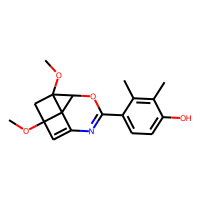
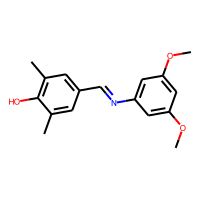
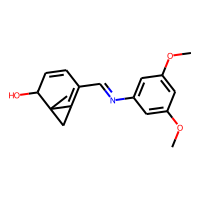
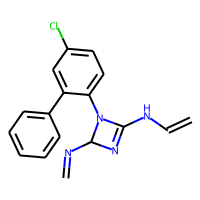
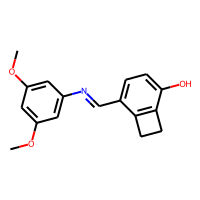
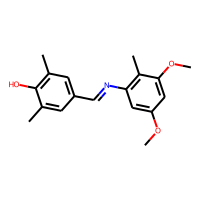

In [44]:
df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]

## Variability Factor: 1.0

### Data

In [45]:
datafile = "generated/BRD4_vf1.0_big.gen_metrics"

In [46]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'BRD4_vf1.0_big'

In [47]:
df = pd.read_csv(datafile, sep=" ")
df.head()

lig_name  sample_idx   lig_norm  lig_variance  lig_gen_norm  \
0  ligand-1_min           0  32.281212           NaN     29.789688   
1  ligand-1_min           1  32.281212           NaN     29.306690   
2  ligand-1_min           2  32.281212           NaN     29.646959   
3  ligand-1_min           3  32.281212           NaN     30.201521   
4  ligand-1_min           4  32.281212           NaN     29.641863   

   lig_gen_variance  lig_gen_L2_loss  lig_gen_L1_loss  lig_latent_norm  \
0               NaN        37.707005       863.745728        24.648478   
1               NaN        40.843384       878.057983        23.189077   
2               NaN        60.131561       996.283691        23.341806   
3               NaN        55.303509       960.407410        22.489714   
4               NaN        43.960197       922.967407        23.811268   

   lig_latent_variance  ...  lig_gen_fit_add_E  lig_gen_fit_add_min_E  \
0                  NaN  ...                NaN                    NaN   
1                  NaN  ...       20765.585460             374.715312   
2                  NaN  ...        2652.599928             484.702831   
3                  NaN  ...        1101.717151              26.766472   
4                  NaN  ...      251641.444323             495.003766   

   lig_gen_fit_add_dE_min  lig_gen_fit_add_min_error  \
0                     NaN                        NaN   
1           -20390.870148                        NaN   
2            -2167.897097                        NaN   
3            -1074.950679                        NaN   
4          -251146.440558                        NaN   

   lig_gen_fit_add_min_time  lig_gen_fit_add_RMSD_min  lig_gen_fit_add_dE_ref  \
0                  0.001074                       NaN                     NaN   
1                  0.015447                  1.448243            20691.995022   
2                  0.012131                  1.051820             2579.009490   
3                  0.008152                  0.615424             1028.126713   
4                  0.015695                  1.943457           251567.853885   

   lig_gen_fit_add_min_dE_ref  lig_gen_fit_add_RMSD_ref  \
0                         NaN                       NaN   
1                  301.124874                       NaN   
2                  411.112393                       NaN   
3                  -46.823966                       NaN   
4                  421.413328                       NaN   

   lig_gen_fit_add_min_RMSD_ref  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  

[5 rows x 125 columns]

Load RMSD calculations (between generated and minimised structures) for each ligand:

In [48]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 89.68%


In [49]:
load_scores(dataroot, prefix, df)

In [50]:
df[df.rmsd_uff > 10][["lig_name", "sample_idx", "rmsd_uff"]]

lig_name  sample_idx  rmsd_uff
9233  ligand-10_min         233  12.20301
9741  ligand-10_min         741  12.12402

### Distributions

#### RMSD

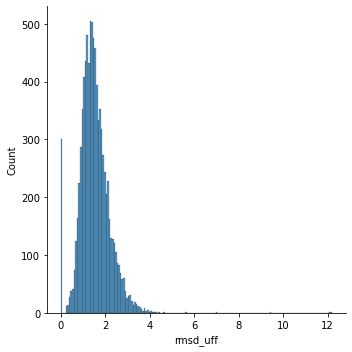

In [51]:
sns.displot(df["rmsd_uff"])
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDuff.png"))

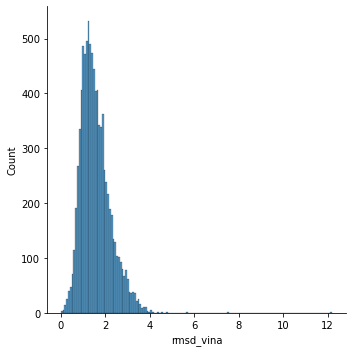

In [52]:
sns.displot(df["rmsd_vina"])
plt.savefig(os.path.join("plots", prefix + "_distRMSDvina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSDvina.png"))

#### QED

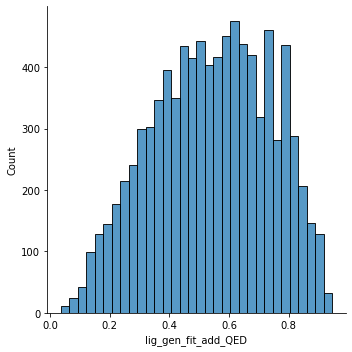

In [53]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

#### Scores

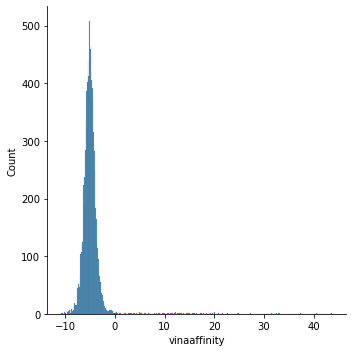

In [54]:
sns.displot(df[f"vinaaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distVina.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distVina.png"))

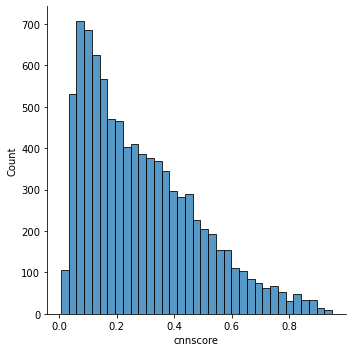

In [55]:
sns.displot(df["cnnscore"])
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNscore.png"))

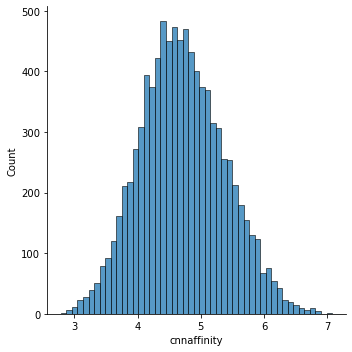

In [56]:
sns.displot(df["cnnaffinity"])
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.png"))

### Simple Statistics

In [57]:
rmsd_statistics(df, maxRMSD)

--- UFF ---
Average RMSD: 1.5091340499553967
Median RMSD: 1.4432999999999998
Percentage of low-RMSD samples: 14.852809991079393%
--- VINA ---
Average RMSD: 1.5603130586529885
Median RMSD: 1.447255
Percentage of low-RMSD samples: 19.201605709188225%


### Correlation

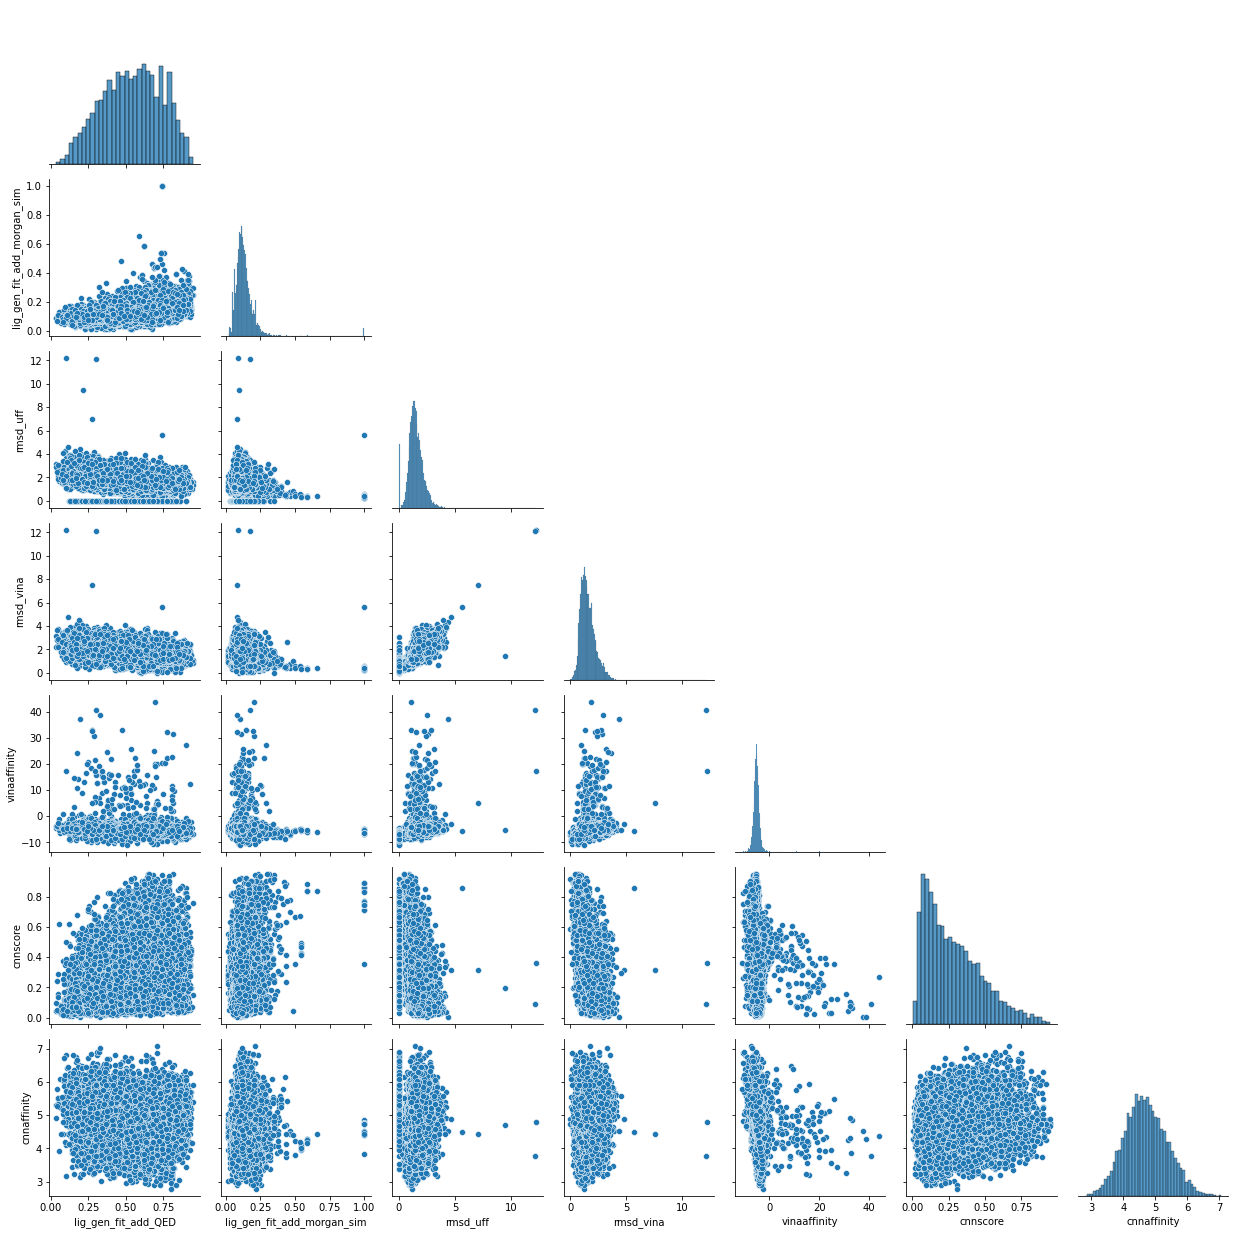

In [58]:
to_plot = [
    f"{blob}_fit_add_QED",
    f"{blob}_fit_add_morgan_sim",
    "rmsd_uff",
    "rmsd_vina",
    "vinaaffinity",
    "cnnscore",
    "cnnaffinity",
]

g = sns.PairGrid(df[to_plot], corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.savefig(os.path.join("plots", prefix + "_correlations.pdf"))
plt.savefig(os.path.join("plots", prefix + "_correlations.png"))

### Filter Molecules

In [59]:
df_filtered = filter(df, maxRMSD, minQED)

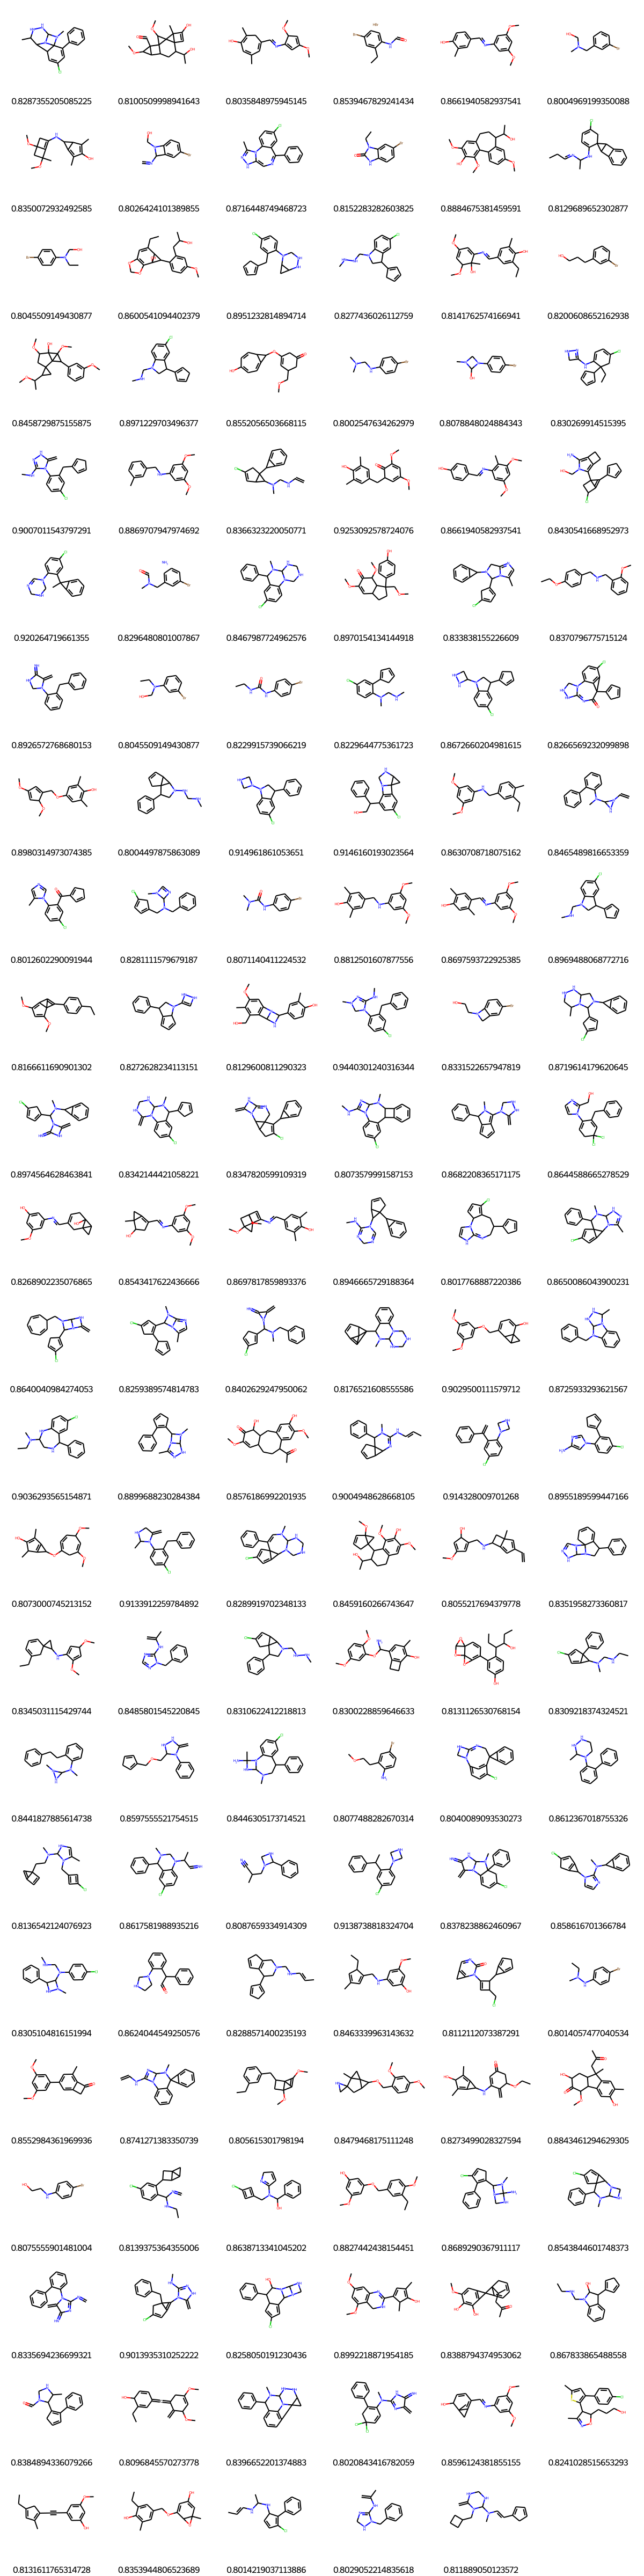

In [60]:
img = PandasTools.FrameToGridImage(
    df_filtered,
    column=f"mol_{blob}",
    legendsCol="lig_gen_fit_add_QED",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [61]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [62]:
len(df_filtered)

143

lig_name  sample_idx  lig_gen_fit_add_morgan_sim  rmsd_uff  \
6951  ligand-7_min         951                    0.185714   0.00000   
2557  ligand-3_min         557                    0.113636   0.00000   
7410  ligand-8_min         410                    0.171429   0.00000   
7882  ligand-8_min         882                    0.123288   0.00002   
6208  ligand-7_min         208                    0.431034   0.48095   
2837  ligand-3_min         837                    0.411765   0.60640   
6999  ligand-7_min         999                    0.135135   0.00000   
2732  ligand-3_min         732                    0.133333   0.00000   
4365  ligand-5_min         365                    0.222222   1.30357   
7205  ligand-8_min         205                    0.191781   0.00000   
2637  ligand-3_min         637                    0.137931   0.00000   
7450  ligand-8_min         450                    0.120000   1.12375   
6017  ligand-7_min          17                    0.140845   0.00099   
4945  ligand-5_min         945                    0.281250   1.01229   
6151  ligand-7_min         151                    0.253731   0.71228   
2126  ligand-3_min         126                    0.170732   0.00000   
6691  ligand-7_min         691                    0.150685   0.86338   
4511  ligand-5_min         511                    0.169231   0.82153   
4522  ligand-5_min         522                    0.272727   0.64970   
4958  ligand-5_min         958                    0.392857   0.63219   
7090  ligand-8_min          90                    0.106061   0.00000   
6615  ligand-7_min         615                    0.202703   0.90871   
6088  ligand-7_min          88                    0.169014   0.89137   
6748  ligand-7_min         748                    0.253731   0.82353   
4850  ligand-5_min         850                    0.171053   0.91278   
6777  ligand-7_min         777                    0.108108   0.95219   
4043  ligand-5_min          43                    0.138889   0.88063   
6550  ligand-7_min         550                    0.141026   0.96827   
6046  ligand-7_min          46                    0.205882   1.34636   
2486  ligand-3_min         486                    0.293333   0.83219   
6593  ligand-7_min         593                    0.152778   0.00086   
4720  ligand-5_min         720                    0.200000   0.80271   
6063  ligand-7_min          63                    0.246377   0.96995   
7634  ligand-8_min         634                    0.230769   1.11893   
7406  ligand-8_min         406                    0.290909   0.71870   
6998  ligand-7_min         998                    0.152778   0.94388   
7325  ligand-8_min         325                    0.102564   1.07862   
4832  ligand-5_min         832                    0.131579   1.05539   
7189  ligand-8_min         189                    0.196970   0.63798   
7486  ligand-8_min         486                    0.230769   1.06656   

      rmsd_vina  vinaaffinity  cnnscore  cnnaffinity  \
6951    0.08104      -9.72304  0.706543     6.176190   
2557    0.28206      -7.63070  0.812735     5.611140   
7410    0.33984      -8.50316  0.579408     5.333472   
7882    0.44924      -7.54228  0.515617     5.247090   
6208    0.49991      -8.64576  0.866892     6.138769   
2837    0.58596      -7.02629  0.748085     5.785309   
6999    0.58959      -8.94793  0.322323     5.844628   
2732    0.63007      -8.18744  0.483333     5.380066   
4365    0.65026      -7.57453  0.503657     5.712246   
7205    0.67599      -8.65806  0.707623     5.642938   
2637    0.67769      -7.08825  0.538842     5.390082   
7450    0.68003      -7.38229  0.453193     5.030210   
6017    0.71608      -7.65153  0.294518     5.384803   
4945    0.72601      -7.54335  0.473629     5.632873   
6151    0.72765      -7.47683  0.645176     5.586272   
2126    0.72864      -7.96767  0.855162     5.897799   
6691    0.72867      -7.90495  0.571886     6.034575   
4511    0.73616      -7.46242  0.494158     5.343
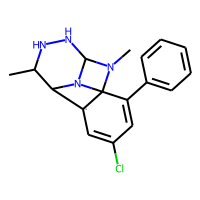
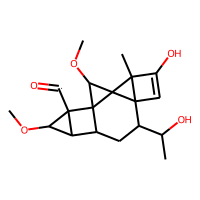
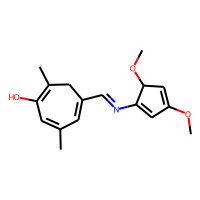
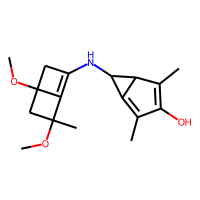
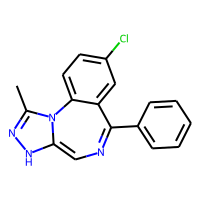
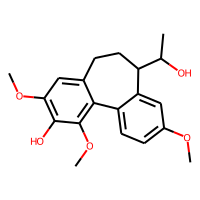
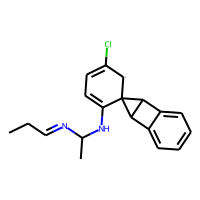
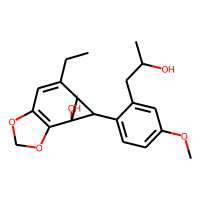
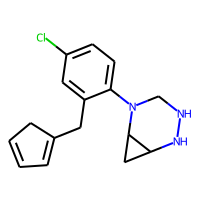
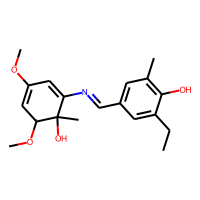
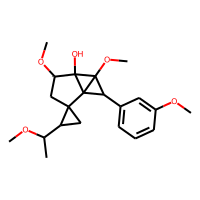
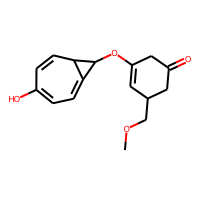
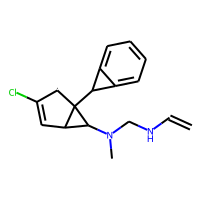
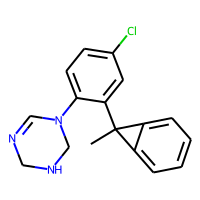
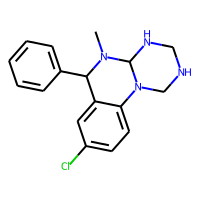
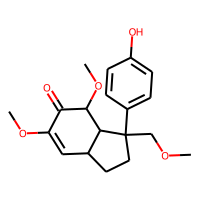
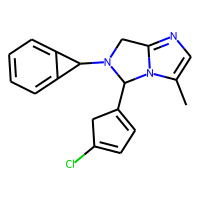
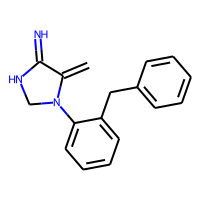
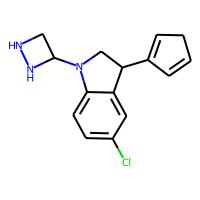
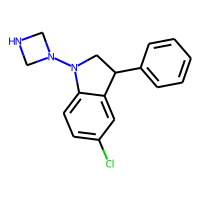
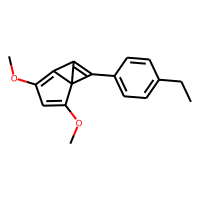
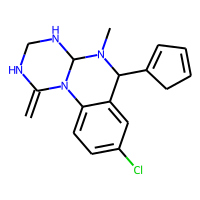
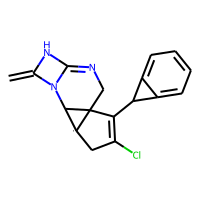
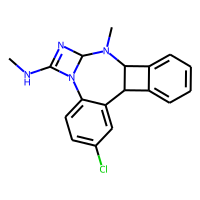
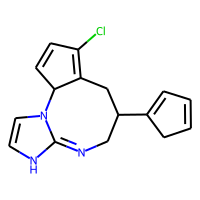
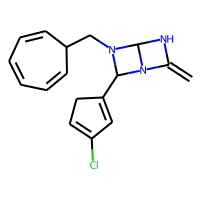
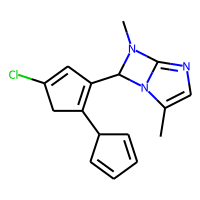
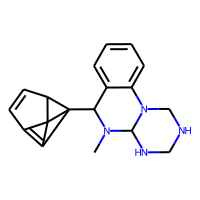
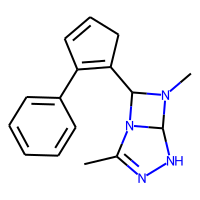
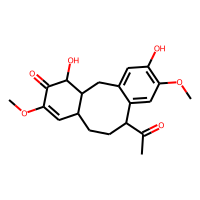
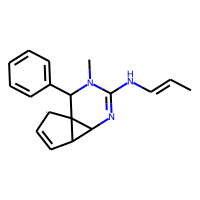
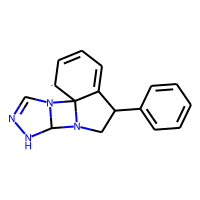
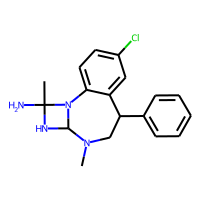
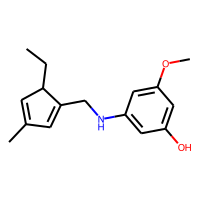
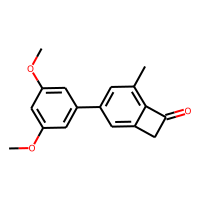
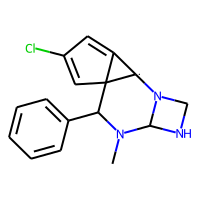
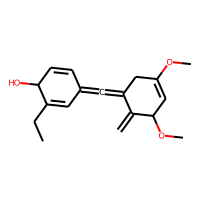
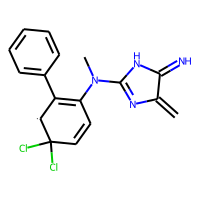
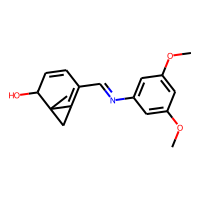
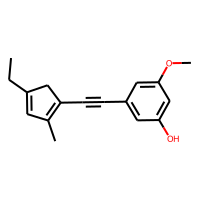

In [63]:
df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]

In [64]:
print(len(df_filtered), len(df_filtered[df_filtered.vinaaffinity < maxVina][dfcolumns]))

143 40


lig_name  sample_idx  lig_gen_fit_add_morgan_sim  rmsd_uff  \
6951  ligand-7_min         951                    0.185714   0.00000   
2557  ligand-3_min         557                    0.113636   0.00000   
7848  ligand-8_min         848                    0.233333   0.43978   
6208  ligand-7_min         208                    0.431034   0.48095   
3650  ligand-4_min         650                    0.311111   0.49113   
2837  ligand-3_min         837                    0.411765   0.60640   
7205  ligand-8_min         205                    0.191781   0.00000   
6619  ligand-7_min         619                    0.236111   1.05881   
3927  ligand-4_min         927                    0.208333   1.49809   
2126  ligand-3_min         126                    0.170732   0.00000   
5569  ligand-6_min         569                    0.173913   0.00009   
7256  ligand-8_min         256                    0.241935   1.09026   
6258  ligand-7_min         258                    0.296875   1.31667   
7406  ligand-8_min         406                    0.290909   0.71870   
7759  ligand-8_min         759                    0.164384   1.03659   

      rmsd_vina  vinaaffinity  cnnscore  cnnaffinity  \
6951    0.08104      -9.72304  0.706543     6.176190   
2557    0.28206      -7.63070  0.812735     5.611140   
7848    0.40914      -6.42757  0.742990     4.752776   
6208    0.49991      -8.64576  0.866892     6.138769   
3650    0.55045      -5.25869  0.948652     4.868724   
2837    0.58596      -7.02629  0.748085     5.785309   
7205    0.67599      -8.65806  0.707623     5.642938   
6619    0.71121      -6.78059  0.727319     6.145895   
3927    0.72695      -5.34086  0.709884     3.977118   
2126    0.72864      -7.96767  0.855162     5.897799   
5569    0.73172      -5.96086  0.782893     4.882639   
7256    0.75078      -6.42385  0.824178     4.928280   
6258    0.81280      -6.81304  0.754828     5.919124   
7406    0.95613      -8.15464  0.789499     5.158266   
7759    0.99780      -6.95440  0.712642     4.908086   

                                            mol_lig_gen  
6951  <img data-content="rdkit/molecule" src="data:i...  
2557  <img data-content="rdkit/molecule" src="data:i...  
7848  <img data-content="rdkit/molecule" src="data:i...  
6208  <img data-content="rdkit/molecule" src="data:i...  
3650  <img data-content="rdkit/molecule" src="data:i...  
2837  <img data-content="rdkit/molecule" src="data:i...  
7205  <img data-content="rdkit/molecule" src="data:i...  
6619  <img data-content="rdkit/molecule" src="data:i...  
3927  <img data-content="rdkit/molecule" src="data:i...  
2126  <img data-content="rdkit/molecule" src="data:i...  
5569  <img data-content="rdkit/molecule" src="data:i...  
7256  <img data-content="rdkit/molecule" src="data:i...  
6258  <img data-content="rdkit/molecule" src="data:i...  
7406  <img data-content="rdkit/molecule" src="data:i...  
7759  <img data-content="rdkit/molecule" src="data:i...
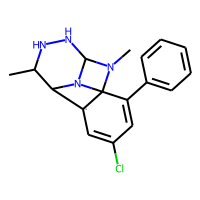
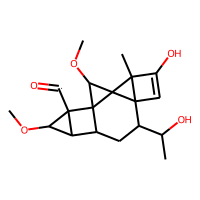
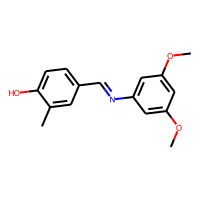
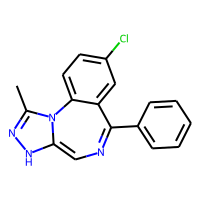
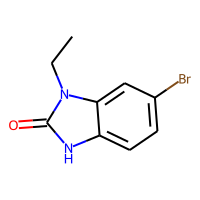
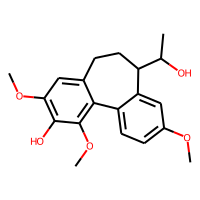
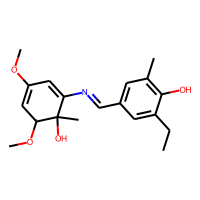
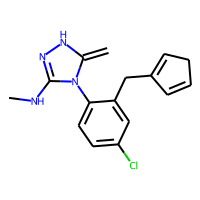
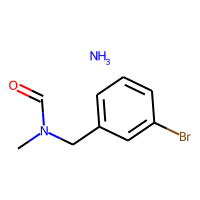
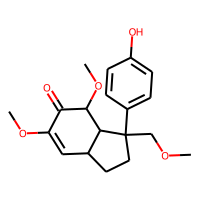
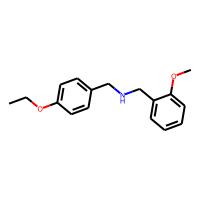
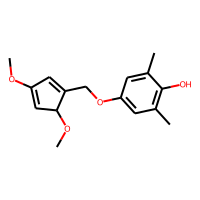
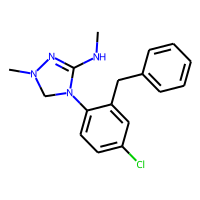
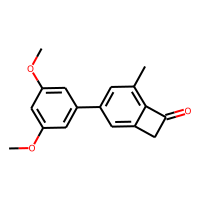
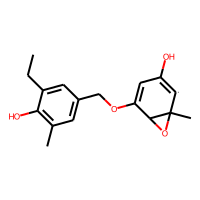

In [65]:
df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]

In [66]:
print(len(df_filtered), len(df_filtered[df_filtered.cnnscore > minCNNscore][dfcolumns]))

143 15


## BRD4 Inhibitors in Latent Space

Plot ligand latent space for BRD4 inhibitors, obtained with a variance of zero. This correspond to the mean values of the element of the latent space vector.

In [67]:
Lbrd4 = np.zeros((10, 512))

for i in range(10):
    Lbrd4[i, :] = np.loadtxt(f"generated/BRD4_latent_ligand-{i+1}_min_lig_gen_0.latent")

In [68]:
Lbrd4.shape

(10, 512)

In [69]:
df_brd4 = pd.DataFrame.from_dict({f"lig {i+1}": Lbrd4[i, :] for i in range(10)})

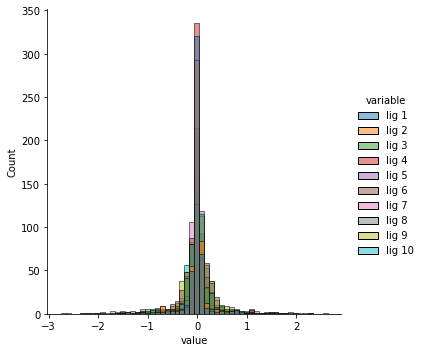

In [70]:
sns.displot(data=df_brd4.melt(), x="value", hue="variable", binwidth=0.1)

Distances between BRD4 inhibitors and latent space center:

In [71]:
np.sqrt(np.sum(Lbrd4**2, axis=1))

array([7.36333252, 7.22376788, 8.38184845, 6.37429692, 8.26164299,
       8.75573171, 8.52044289, 8.12270362, 9.37325271, 9.14345363])

In [72]:
dLbrd4 = distance.squareform(distance.pdist(Lbrd4, "euclidean"))
assert dLbrd4.shape == (10, 10)

<AxesSubplot:>

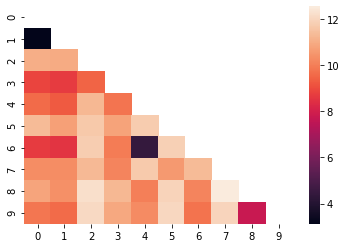

In [73]:
mask = np.zeros_like(dLbrd4)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dLbrd4, mask=mask)


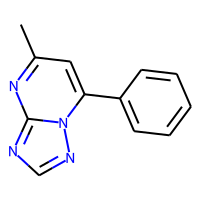
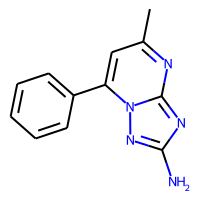
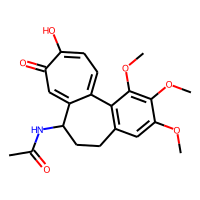
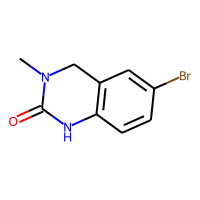
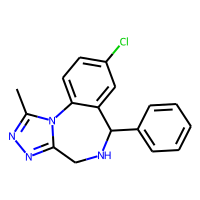
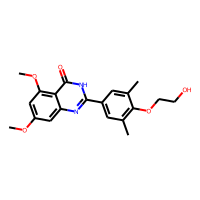
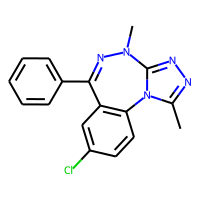
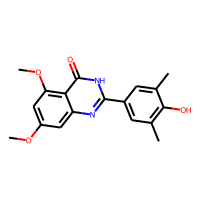
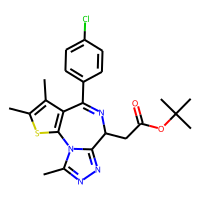
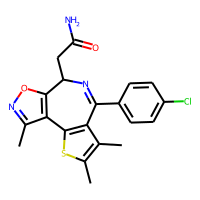
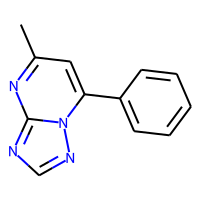
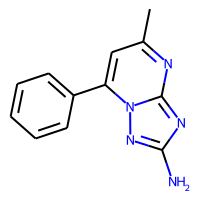
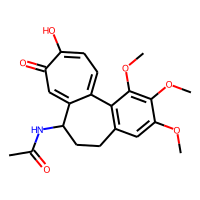
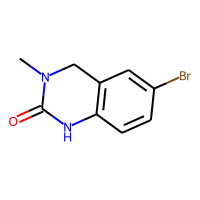
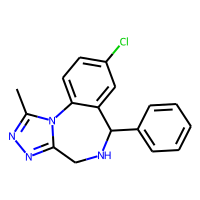
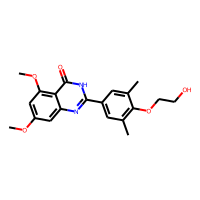
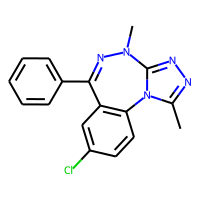
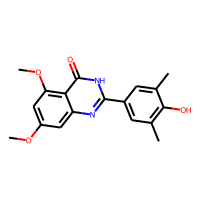
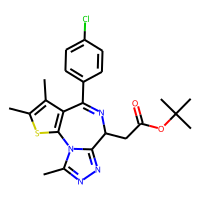
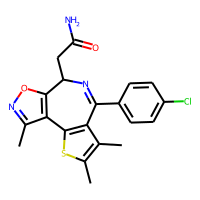

In [74]:
mols = []
for i in range(10):
    file = f"data/BRD4/sdf/ligand-{i+1}_min.sdf"
    mol = next(Chem.SDMolSupplier(file))

    if mol is not None:
        mol.Compute2DCoords()
        mols.append(mol)

assert len(mols) == 10

dfbrd4 = pd.DataFrame(dLbrd4, columns=mols, index=mols)

dfbrd4.style.set_precision(2).background_gradient(
    cmap=sns.cm.rocket, vmin=min(dLbrd4[dLbrd4 > 0.01]), vmax=np.max(dLbrd4)
)

## Prior Sampling (Variability Factor 0.5)

In [75]:
prefix = "BRD4_vf0.5_prior"

In [76]:
df = load_prior(prefix)

RDKit ERROR: [12:53:41] Explicit valence for atom # 20 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not sanitize molecule ending on line 70
RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 20 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] Explicit valence for atom # 22 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not sanitize molecule ending on line 525
RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 22 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not sanitize molecule ending on line 723
RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:53:41] Explicit valence for atom # 7 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not sanitize molecule ending on line 798
RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 7 F

RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 10 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not sanitize molecule ending on line 39432
RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [12:53:41] Explicit valence for atom # 3 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not sanitize molecule ending on line 40007
RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 3 F, 2, is greater than permitted
RDKit ERROR: [12:53:41] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not sanitize molecule ending on line 40401
RDKit ERROR: [12:53:41] ERROR: Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [12:53:41] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [12:53:41] ERROR: Could not

In [77]:
len(df)

937

lig_name sample_idx                                                mol  \
0  ligand-1_min          1  <img data-content="rdkit/molecule" src="data:i...   
1  ligand-1_min          2  <img data-content="rdkit/molecule" src="data:i...   
2  ligand-1_min          3  <img data-content="rdkit/molecule" src="data:i...   
3  ligand-1_min          4  <img data-content="rdkit/molecule" src="data:i...   
4  ligand-1_min          5  <img data-content="rdkit/molecule" src="data:i...   

   vinaaffinity  cnnscore  cnnaffinity       QED  
0      -3.83047  0.265457     4.965426  0.401931  
1      -4.23208  0.399176     4.425670  0.640056  
2      -4.23129  0.328024     3.312456  0.437267  
3      -4.01854  0.748679     3.190544  0.550792  
4      -2.34775  0.711408     2.699791  0.431024
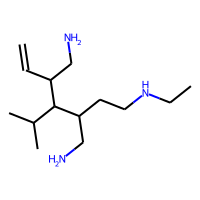
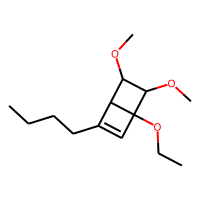
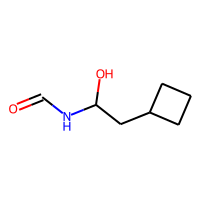
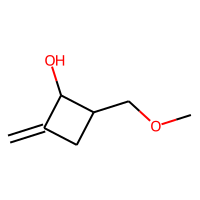
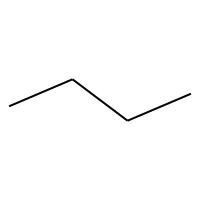

In [78]:
df.head()

### Distributions

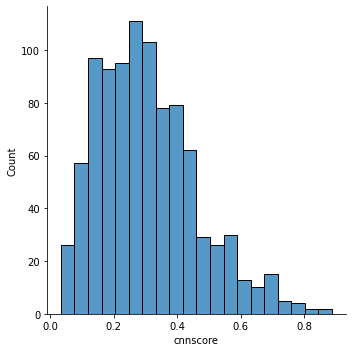

In [79]:
sns.displot(df["cnnscore"])
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.png"))

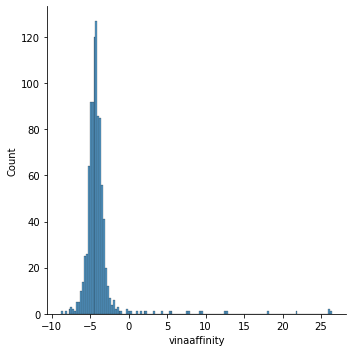

In [80]:
sns.displot(df["vinaaffinity"], binwidth=0.25)
plt.savefig(os.path.join("plots", prefix + "_distVinaaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distVinaaff.png"))

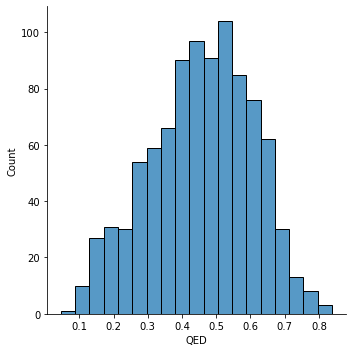

In [81]:
sns.displot(df["QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

### Molecules

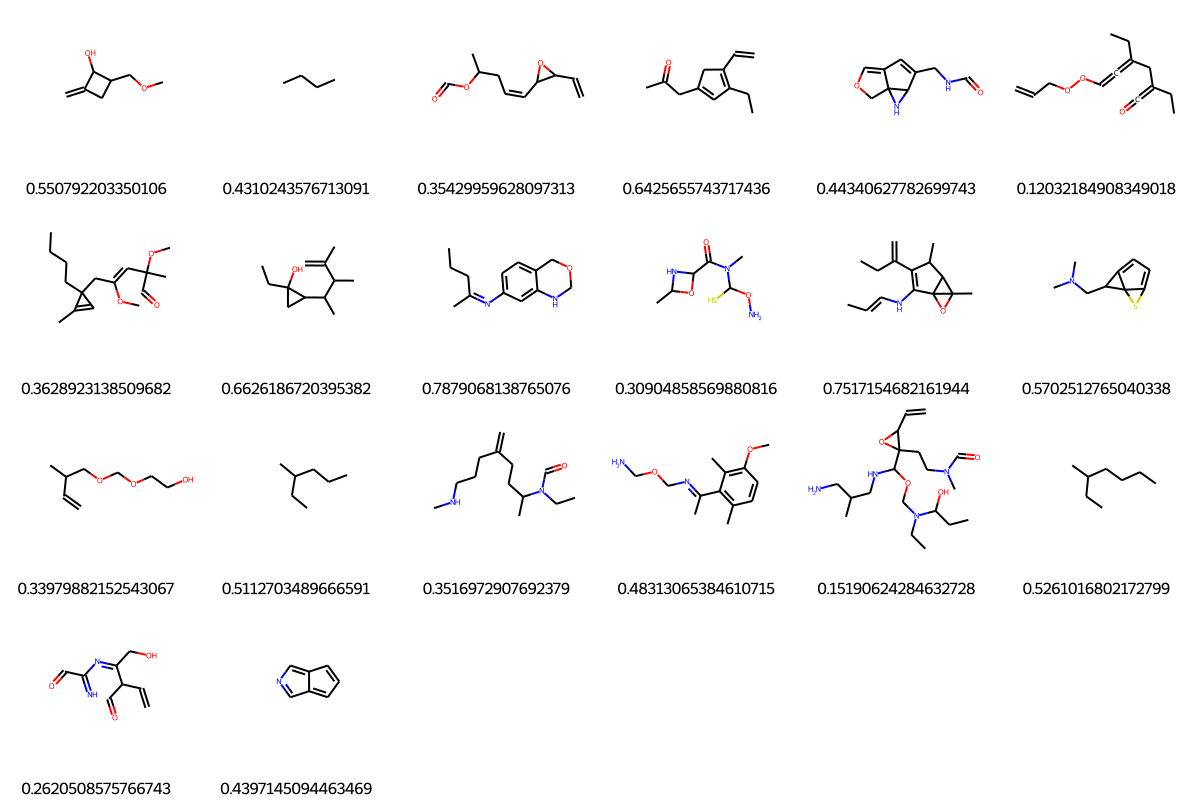

In [82]:
img = PandasTools.FrameToGridImage(
    df[df.cnnscore > minCNNscore],
    column=f"mol",
    legendsCol="QED",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [83]:
img.save(f"plots/{prefix}_minCNNscore-{minCNNscore}.png")

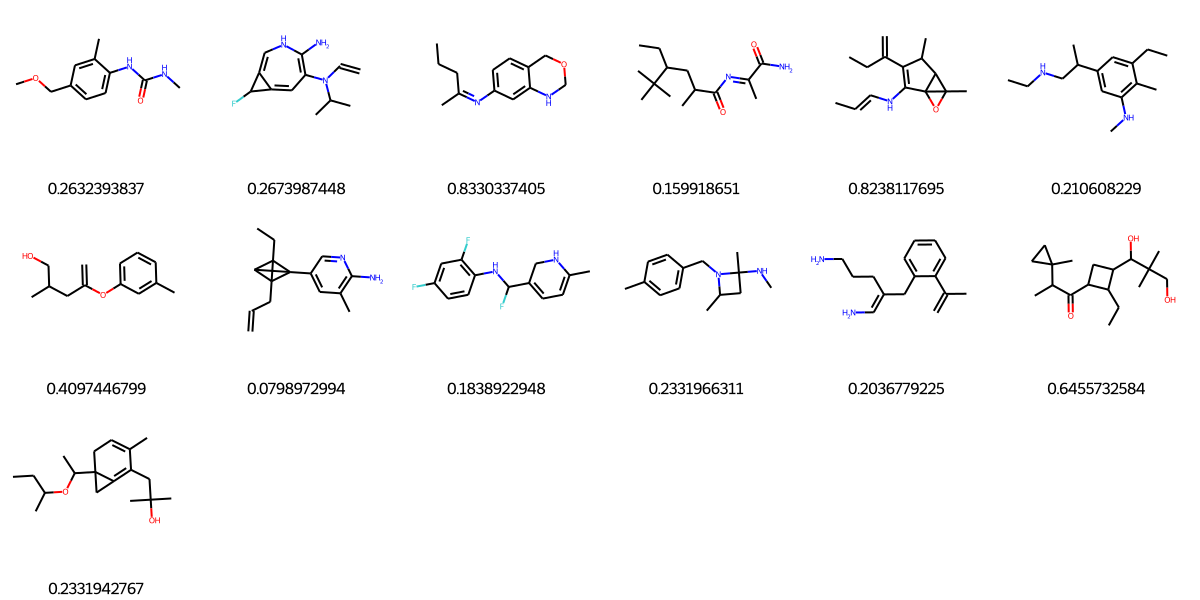

In [84]:
img = PandasTools.FrameToGridImage(
    df[df.QED > 0.75],
    column=f"mol",
    legendsCol="cnnscore",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [85]:
img.save(f"plots/{prefix}_minQED-{0.75}.png")

### Latent Space

In [86]:
L = load_latent(prefix, 1000)

Distribution of the elements of one latent space vector:

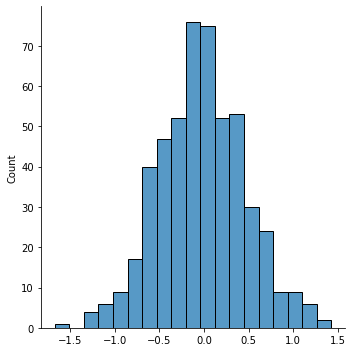

In [87]:
sns.displot(L[0, :])

Distances between prior samples and BRD4 inhibitors:

In [88]:
dd = {}

for i in range(10):
    dist = np.sum((L - Lbrd4[i, :]) ** 2, axis=1) ** 0.5
    dd[f"lig {i}"] = dist

df_dist = pd.DataFrame.from_dict(dd)
df_dist.head()

lig 0      lig 1      lig 2      lig 3      lig 4      lig 5  \
0  12.923293  12.861585  13.112811  12.537793  13.348790  13.966403   
1  13.959085  14.028023  14.415783  13.204762  14.434747  14.191480   
2  14.129332  14.017476  13.828300  13.428172  14.348483  14.320185   
3  13.422890  13.163128  14.500285  13.488116  14.508703  14.349744   
4  12.787021  12.662892  13.425141  12.891386  13.112571  14.599775   

       lig 6      lig 7      lig 8      lig 9  
0  13.699531  13.724337  14.569687  14.351721  
1  14.531960  14.104360  14.751153  14.986621  
2  14.622055  14.270338  14.398663  14.562449  
3  14.346042  13.862961  15.084576  14.929847  
4  13.613743  14.088212  14.718848  14.242440

In [89]:
df_dist.melt()

variable      value
0       lig 0  12.923293
1       lig 0  13.959085
2       lig 0  14.129332
3       lig 0  13.422890
4       lig 0  12.787021
...       ...        ...
9995    lig 9  14.252522
9996    lig 9  14.335241
9997    lig 9  14.680568
9998    lig 9  14.261835
9999    lig 9  14.775590

[10000 rows x 2 columns]

Distribution of distances between prior samples and BRD4 inhibitors:

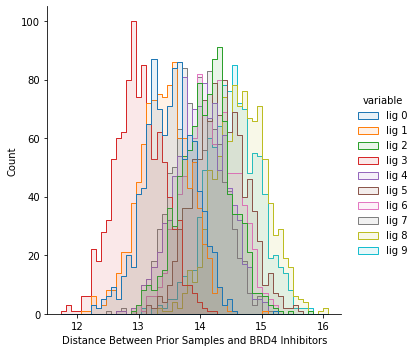

In [90]:
sns.displot(df_dist.melt(), x="value", hue="variable", element="step", alpha=0.1)
plt.xlabel("Distance Between Prior Samples and BRD4 Inhibitors")
plt.savefig(f"plots/{prefix}_BRD4dist.png")
plt.savefig(f"plots/{prefix}_BRD4dist.pdf")

In [91]:
dL = distance.squareform(distance.pdist(L, "euclidean"))

In [92]:
print(np.sqrt(np.sum((L[0, :] - L[1, :]) ** 2)), dL[0, 1], dL[1, 0])

16.55563252467872 16.555632524678725 16.555632524678725


In [93]:
idxs = df[df.cnnscore > minCNNscore]["sample_idx"].to_numpy(dtype=int)

dLf = dL[np.ix_(idxs, idxs)]

<AxesSubplot:>

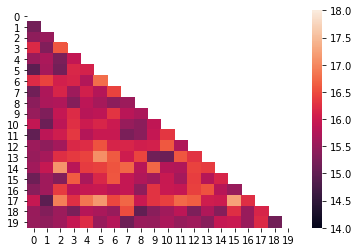

In [94]:
mask = np.zeros_like(dLf)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dLf, mask=mask, vmin=14, vmax=18)


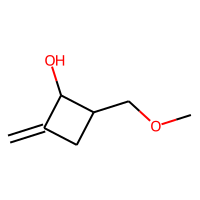
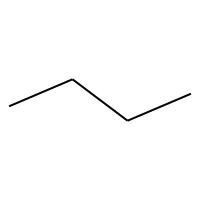
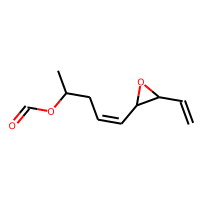
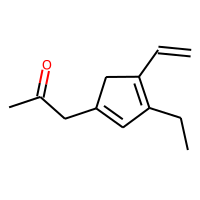
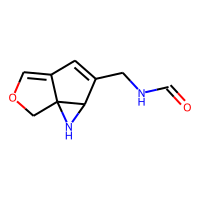
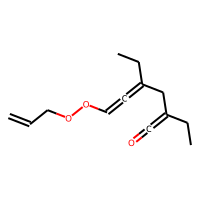
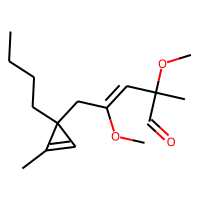
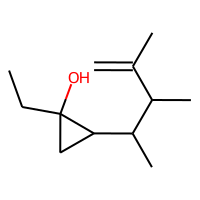
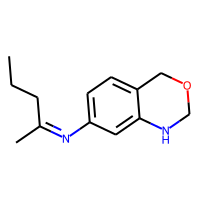
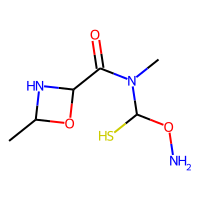
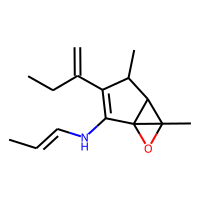
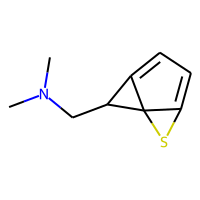
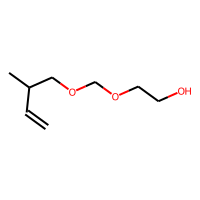
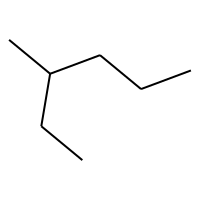
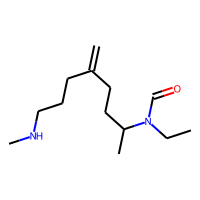
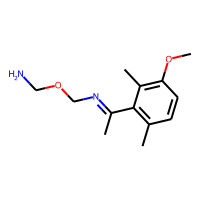
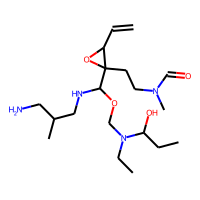
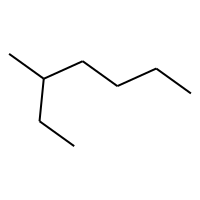
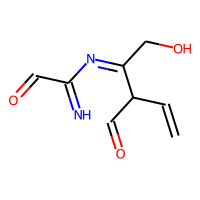
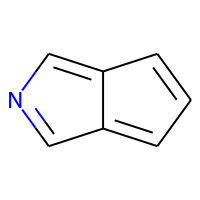
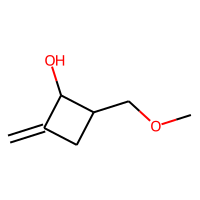
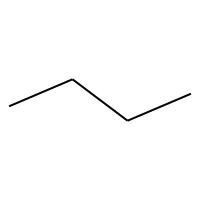
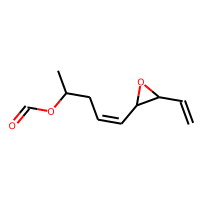
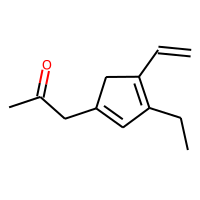
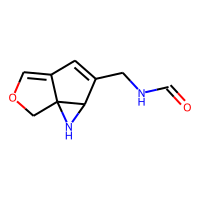
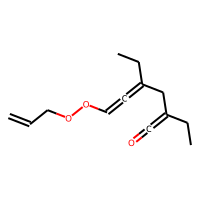
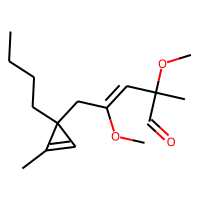
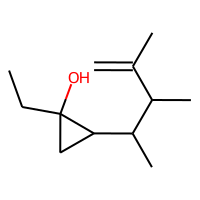
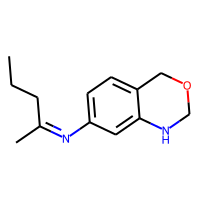
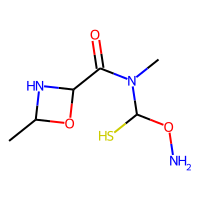
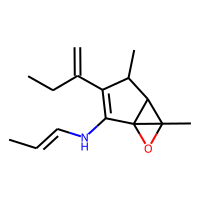
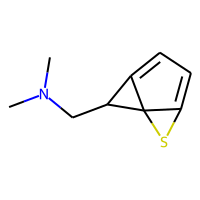
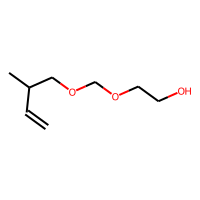
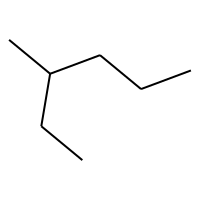
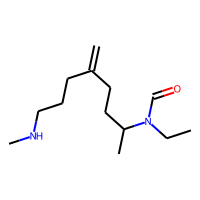
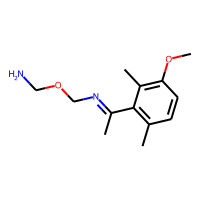
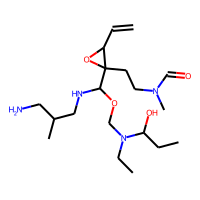
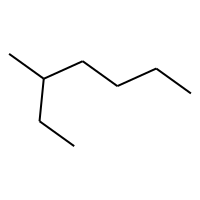
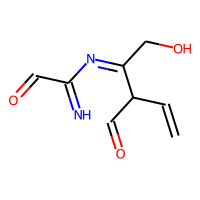
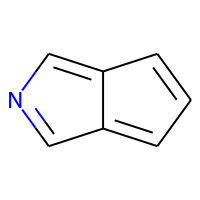

In [95]:
# dLf[np.triu_indices_from(mask)] = np.nan

pd.DataFrame(
    dLf,
    columns=df[df.cnnscore > minCNNscore]["mol"],
    index=df[df.cnnscore > minCNNscore]["mol"],
).style.background_gradient(cmap=sns.cm.rocket, vmin=14, vmax=18)

## Prior Sampling (Variability Factor 1.0)

In [96]:
prefix = "BRD4_vf1.0_prior"

In [97]:
df = load_prior(prefix)

RDKit ERROR: [12:53:42] ERROR: Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [12:53:46] Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [12:53:46] ERROR: Could not sanitize molecule ending on line 123
RDKit ERROR: [12:53:46] ERROR: Explicit valence for atom # 20 C, 5, is greater than permitted
RDKit ERROR: [12:53:46] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [12:53:46] ERROR: Could not sanitize molecule ending on line 338
RDKit ERROR: [12:53:46] ERROR: Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [12:53:46] Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [12:53:46] ERROR: Could not sanitize molecule ending on line 1265
RDKit ERROR: [12:53:46] ERROR: Explicit valence for atom # 13 O, 3, is greater than permitted
RDKit ERROR: [12:53:46] Explicit valence for atom # 18 C, 5, is greater than permitted
RDKit ERROR: [12:53:46] ERROR: Could not san

RDKit ERROR: [12:53:47] ERROR: Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] ERROR: Could not sanitize molecule ending on line 49675
RDKit ERROR: [12:53:47] ERROR: Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] ERROR: Could not sanitize molecule ending on line 52559
RDKit ERROR: [12:53:47] ERROR: Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] ERROR: Could not sanitize molecule ending on line 54121
RDKit ERROR: [12:53:47] ERROR: Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] Explicit valence for atom # 11 O, 3, is greater than permitted
RDKit ERROR: [12:53:47] ERROR: Could

In [98]:
len(df)

957

lig_name sample_idx                                                mol  \
0  ligand-1_min          0  <img data-content="rdkit/molecule" src="data:i...   
1  ligand-1_min          2  <img data-content="rdkit/molecule" src="data:i...   
2  ligand-1_min          3  <img data-content="rdkit/molecule" src="data:i...   
3  ligand-1_min          5  <img data-content="rdkit/molecule" src="data:i...   
4  ligand-1_min          6  <img data-content="rdkit/molecule" src="data:i...   

   vinaaffinity  cnnscore  cnnaffinity       QED  
0      -3.52715  0.315081     4.085036  0.266790  
1      -5.21736  0.066271     4.905205  0.304402  
2      -3.84302  0.218872     5.263550  0.501888  
3      -6.06711  0.334134     4.471736  0.700967  
4      -3.95525  0.317902     5.351089  0.415448
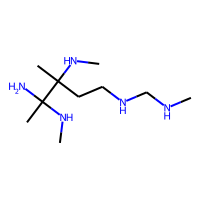
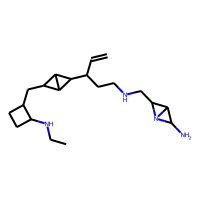
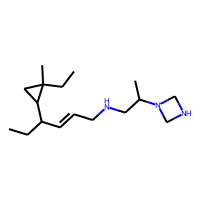
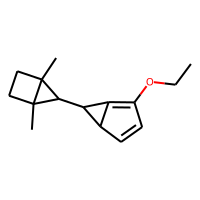
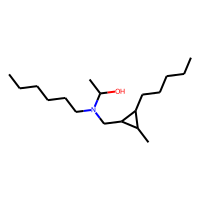

In [99]:
df.head()

### Distributions

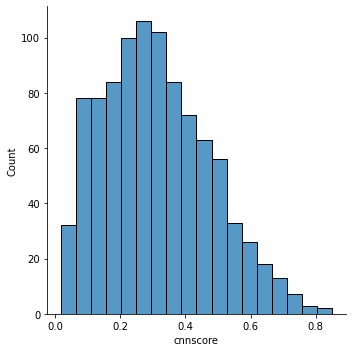

In [100]:
sns.displot(df["cnnscore"])
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distCNNaff.png"))

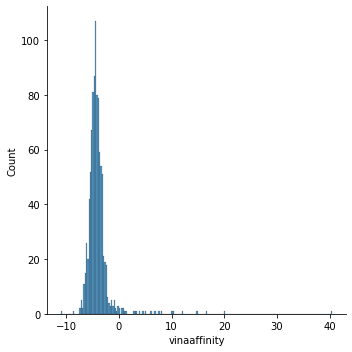

In [101]:
sns.displot(df["vinaaffinity"], binwidth=0.25)
plt.savefig(os.path.join("plots", prefix + "_distVinaaff.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distVinaaff.png"))

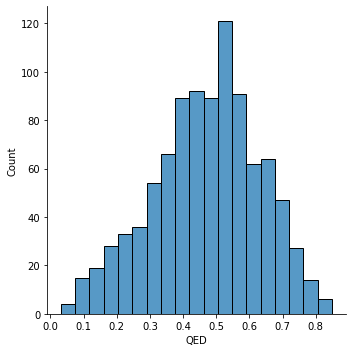

In [102]:
sns.displot(df["QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

### Molecules

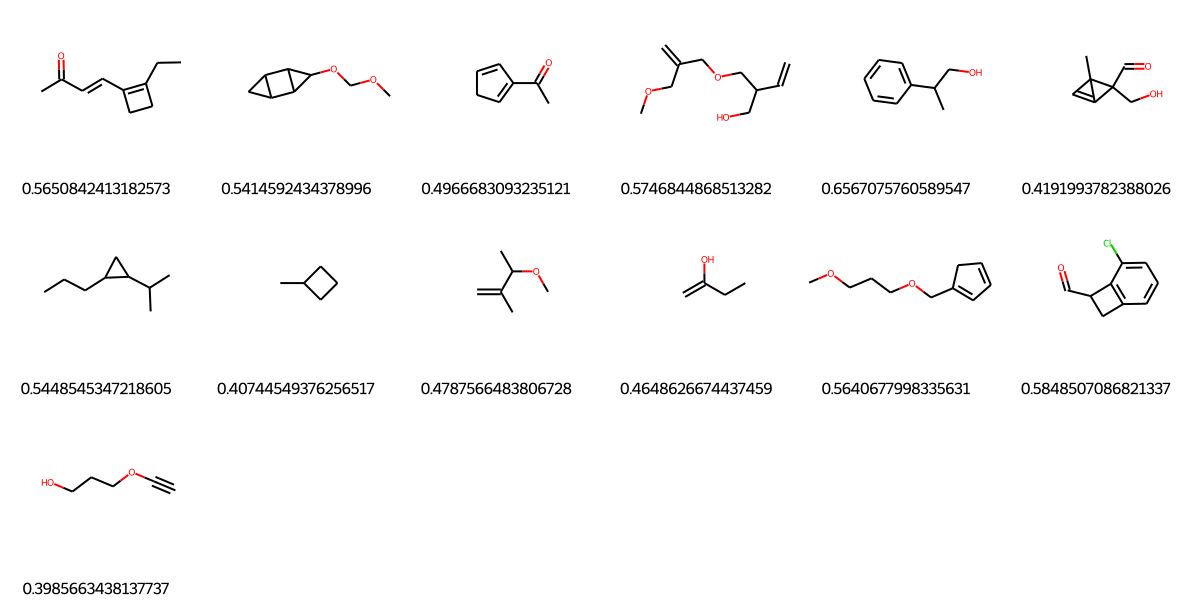

In [103]:
img = PandasTools.FrameToGridImage(
    df[df.cnnscore > 0.7],
    column=f"mol",
    legendsCol="QED",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [104]:
img.save(f"plots/{prefix}_minCNNscore-{minCNNscore}.png")

### Latent Space

In [105]:
L = load_latent(prefix, 1000)

In [106]:
dL = distance.squareform(distance.pdist(L, "euclidean"))

In [107]:
print(np.sqrt(np.sum((L[0, :] - L[1, :]) ** 2)), dL[0, 1], dL[1, 0])

32.17522129768496 32.175221297684956 32.175221297684956
